In [3]:
import findspark
findspark.init()
from pyspark.sql import functions
from datetime import datetime
import pytz
from pyspark.sql.functions import * #col,window, count, lit
from pyspark.sql.types import StringType, FloatType, Row, StructType, StructField
import pandas as pd

In [4]:
import pyspark

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("INF583 Project") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

In [5]:
# Reading a JSON file
df = spark.read.json("French/*")

### Question1: most frequent words in a given time period

In [6]:
## Converting time string format
def getDate(x):
    if x is not None:
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None
    
## UDF declaration
date_fn = functions.udf(getDate, StringType())

In [7]:
df1 = df.withColumn("created_at", functions.to_utc_timestamp(date_fn("created_at"),"UTC"))
df1.select("created_at").show(5)

+-------------------+
|         created_at|
+-------------------+
|2020-01-31 22:59:55|
|2020-01-31 22:59:57|
|2020-01-31 22:59:57|
|2020-01-31 22:59:58|
|2020-01-31 22:59:59|
+-------------------+
only showing top 5 rows



In [486]:
df1.createOrReplaceTempView("tweet_data")

In [178]:
begin_time = "'2020-02-01 22:59:55'"
end_time = "'2020-02-01 23:59:57'"
tmp = spark.sql("SELECT * FROM tweet_data t WHERE t.created_at between {} and {}".format(begin_time, end_time))

In [179]:
tmp.count()

3781

In [8]:
def frequent_words(x):
    ## split the sentences by " ", "'" and "’"
    tweetsWords = x.withColumn("words", functions.split(x["text"], " "))
    words = tweetsWords.withColumn("words_separated", functions.explode(tweetsWords["words"])).select("words_separated")
    tweetsWords2 = words.withColumn("words", functions.split(words["words_separated"], "'"))
    words2 = tweetsWords2.withColumn("words_separated", functions.explode(tweetsWords2["words"])).select("words_separated")
    tweetsWords3 = words2.withColumn("words", functions.split(words2["words_separated"], "’"))
    words3 = tweetsWords3.withColumn("words_separated", functions.explode(tweetsWords3["words"])).select("words_separated")
    
    words = words3.withColumn("words_separated", functions.lower(words3["words_separated"]))
    counts_tmp = words.groupBy("words_separated").count()
    counts = counts_tmp.orderBy(counts_tmp['count'].desc())
    return counts

In [260]:
counts = frequent_words(tmp)

In [261]:
counts.show(10)

+---------------+-----+
|words_separated|count|
+---------------+-----+
|             rt| 2140|
|             de| 1439|
|            est|  912|
|             la|  796|
|             le|  767|
|               |  746|
|             je|  695|
|              c|  648|
|            les|  592|
|             en|  567|
+---------------+-----+
only showing top 10 rows



### Question2: most frequent words in a given time period after removing stopwords.

In [458]:
import json
import string

In [459]:
with open("stop_words_french.json",'r') as load_f:
    stop_words_french = json.load(load_f)

## add pounctuations to the list of stop words
puncs = list(string.punctuation)
puncs.append('')
stop_words_french.extend(puncs)

In [460]:
sc =spark.sparkContext
stop_words_french = sc.broadcast(stop_words_french)

In [278]:
remove_stop_words_count = counts.filter(counts["words_separated"].isin(stop_words_french.value)== False)
remove_stop_words_count.show(10)

+---------------+-----+
|words_separated|count|
+---------------+-----+
|             rt| 2140|
|          faire|  129|
|             as|   95|
|         jamais|   75|
|          temps|   68|
|            ans|   64|
|           faut|   61|
|       vraiment|   59|
|            vie|   57|
|            dit|   57|
+---------------+-----+
only showing top 10 rows



### Question 3:  the frequent seasonal words

In [162]:
from pytz import timezone
def getTime(x):
    if x is not None:
        ### change the time zone to France and only focus on the time(ignore date)
        fr_tz = timezone('Europe/Paris') 
        return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).astimezone(fr_tz).strftime("%H:%M:%S"))
    else:
        return None
    
## UDF declaration
time_fn = functions.udf(getTime, StringType())

In [181]:
df2 = df.withColumn("created_at", time_fn("created_at"))
df2.select("created_at").show(5)

+----------+
|created_at|
+----------+
|  23:59:55|
|  23:59:57|
|  23:59:57|
|  23:59:58|
|  23:59:59|
+----------+
only showing top 5 rows



In [213]:
df2.createOrReplaceTempView("tweet_data")
## We define 18 p.m. to 6 a.m  as evening (France: UTC+1)
begin_time = "'06:00:00'"
end_time = "'18:00:00'"
daytime = spark.sql("SELECT * FROM tweet_data t WHERE t.created_at between {} and {}".format(begin_time, end_time))
evening = spark.sql("SELECT * FROM tweet_data t WHERE t.created_at not between {} and {}".format(begin_time, end_time))

In [205]:
print("tweeter's number in daytime: {}".format(daytime.count()))
print("tweeter's number in evening: {}".format(evening.count()))

tweeter's number in daytime: 271068
tweeter's number in evening: 285944


In [276]:
### compare the first 20 frequent word afterremoving stop words
daytime_counts = frequent_words(daytime).filter(col("words_separated").isin(stop_words_french.value)== False)
evening_counts = frequent_words(evening).filter(col("words_separated").isin(stop_words_french.value)== False)
daytime_counts.show(50)
evening_counts.show(50)

+---------------+------+
|words_separated| count|
+---------------+------+
|             rt|162151|
|          faire|  8805|
|            dit|  4993|
|             as|  4339|
|         jamais|  4266|
|       vraiment|  4073|
|            vie|  3974|
|           faut|  3932|
|            ans|  3641|
|            mdr|  3141|
|           voir|  3131|
|              2|  3023|
|           veux|  2899|
|           aime|  2851|
|          monde|  2826|
|         france|  2766|
|          temps|  2658|
|            oui|  2647|
|             😭|  2607|
|           jour|  2569|
|           déjà|  2513|
|          parle|  2509|
|            wsh|  2386|
|           sais|  2368|
|            mec|  2305|
|           avez|  2278|
|        twitter|  2267|
|              1|  2204|
|           mère|  2169|
|           êtes|  2165|
|              3|  2154|
|          vidéo|  2115|
|           vois|  2090|
|           mort|  2034|
|            dis|  2016|
|          petit|  1996|
|           vrai|  1976|
|

In [279]:
frq_word_daytime =daytime_counts.limit(100).select("words_separated")
frq_word_evening =evening_counts.limit(100).select("words_separated")
print("The frequent seasonal words during daytime:")
frq_word_daytime.subtract(frq_word_evening).show()
print("The frequent seasonal words during evening:")
frq_word_evening.subtract(frq_word_daytime).show()

The frequent seasonal words during daytime:
+---------------+
|words_separated|
+---------------+
|        février|
|           2020|
|        journée|
|            de…|
|          homme|
|          place|
|       français|
|          paris|
+---------------+

The frequent seasonal words during evening:
+---------------+
|words_separated|
+---------------+
|          mdrrr|
|         demain|
|           nuit|
|          crois|
|            ptn|
|         filles|
|        prendre|
|           beau|
+---------------+



### Question 4: anomaly detection in time series

In [41]:
# df.printSchema()

In [8]:
%matplotlib inline
import csv
from gnip_trend_detection.analysis import rebin,analyze,plot
from gnip_trend_detection import utils
from gnip_trend_detection import models
import argparse
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib
try:
    import ConfigParser as configparser
except ImportError:
    import configparser

In [9]:
df3 = df1.withColumn("hashtags",col("entities.hashtags")).select("hashtags","created_at")
df3 = df3.withColumn("hashtags", functions.explode("hashtags"))
df3 = df3.withColumn("hashtags",functions.lower(col("hashtags.text")))
df3.show()

+----------------+-------------------+
|        hashtags|         created_at|
+----------------+-------------------+
| flashbackfriday|2020-01-31 23:00:01|
|           ggrmc|2020-01-31 23:00:11|
|         truchot|2020-01-31 23:00:11|
|      niveauzero|2020-01-31 23:00:11|
|            love|2020-01-31 23:00:17|
|            fm20|2020-01-31 23:00:23|
|        chaelisa|2020-01-31 23:00:28|
|          brexit|2020-01-31 23:00:33|
|               r|2020-01-31 23:00:35|
|    bénédictions|2020-01-31 23:00:35|
|           wpmoy|2020-01-31 23:00:58|
|     coronavirus|2020-01-31 23:01:19|
|    coronarvirus|2020-01-31 23:01:19|
|          brexit|2020-01-31 23:01:23|
|              ue|2020-01-31 23:01:28|
|              om|2020-01-31 23:01:45|
|edouardphillippe|2020-01-31 23:01:54|
|           havre|2020-01-31 23:01:54|
|fonctionpublique|2020-01-31 23:01:55|
|  bonneannee2020|2020-01-31 23:01:55|
+----------------+-------------------+
only showing top 20 rows



In [10]:
counts_tmp = df3.groupBy("hashtags").count()
counts = counts_tmp.orderBy(counts_tmp['count'].desc())
frequent_hashtags_10_count = counts.limit(10)
frequent_hashtags_10_count.show()

frequent_hashtags_10 = frequent_hashtags_10_count.select("hashtags").collect()
frequent_hashtags_10 =[i[0] for i in frequent_hashtags_10]
frequent_hashtags_10

+-------------+-----+
|     hashtags|count|
+-------------+-----+
|     concours| 1133|
|  coronavirus|  908|
|       macron|  820|
|         mila|  723|
|         lrem|  563|
|    retraites|  557|
| giletsjaunes|  541|
|        paris|  537|
| iheartawards|  455|
|asimforthewin|  404|
+-------------+-----+



['concours',
 'coronavirus',
 'macron',
 'mila',
 'lrem',
 'retraites',
 'giletsjaunes',
 'paris',
 'iheartawards',
 'asimforthewin']

In [449]:
## create a csv file for each hashtag, each line presents tweet count for each period
period = "10 minutes"  # You can replace this with other time intervals, e.g. 1 second, 1 day 12 hours, 2 minutes, etc.
name_to_save = period.split(" ")[0]+period.split(" ")[1]

for i in range(10):
    q4_tmp = df3.filter(df3["hashtags"] == frequent_hashtags_10[i])
    q4_tmp = q4_tmp.orderBy(q4_tmp['created_at'])
    w = q4_tmp.groupBy(window("created_at", period)).agg(count("created_at").alias("count"))
    q4_tmp2 = w.orderBy('window')
    q4_tmp2 = w.select(w.window.start.cast("string").alias("start_time_stamp"), "count").orderBy('start_time_stamp')
    q4_tmp2 = q4_tmp2.withColumn('counter name', lit("#"+frequent_hashtags_10[i]))
    q4_tmp2 = q4_tmp2.withColumn('interval_duration_in_sec', lit(600)) ### change this number depend on period 600s = 10 mins
    q4_tmp2 = q4_tmp2.select("start_time_stamp","interval_duration_in_sec","count","counter name")
    q4_tmp2.toPandas().to_csv('hashtags/{}_{}.csv'.format(frequent_hashtags_10[i], name_to_save), header = False, index = False)

In [450]:
config = configparser.ConfigParser()
config.read("config.cfg")

['config.cfg']

In [451]:
plt.rcParams['figure.dpi'] = 400
### ploting the fitures
def showimg(img_path,m,n):
    img_num=len(os.listdir(img_path))
    img_list=os.listdir(img_path)

    for i in range(img_num): #
        img_name=img_path+'/'+img_list[i] 
        img=plt.imread(img_name)
        plt.subplot(m,n,i+1)
        plt.title(img_list[i],fontsize='xx-small')
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


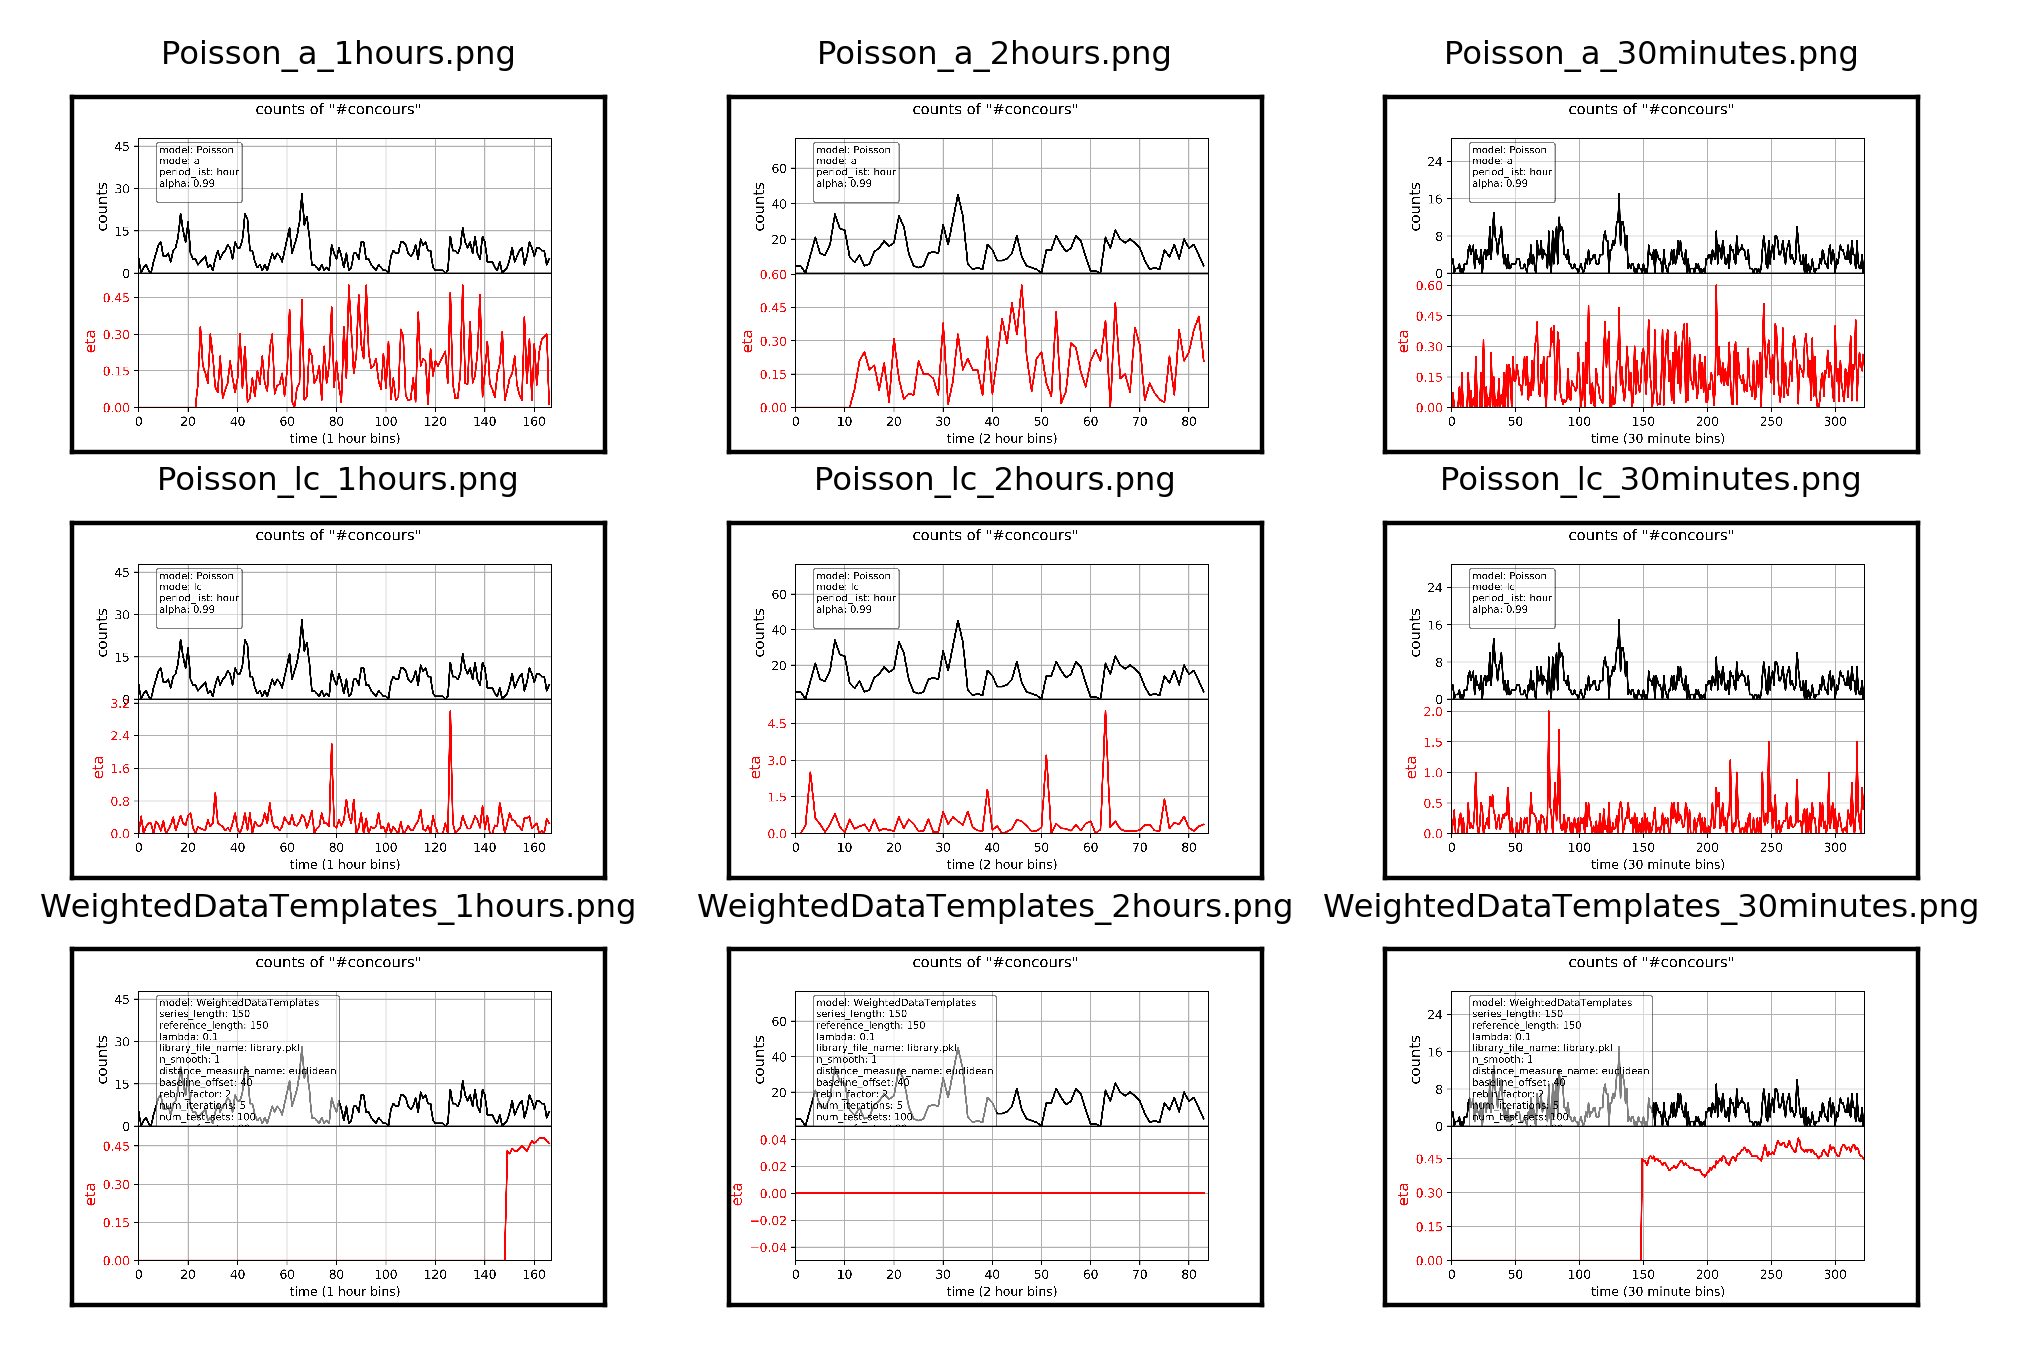

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


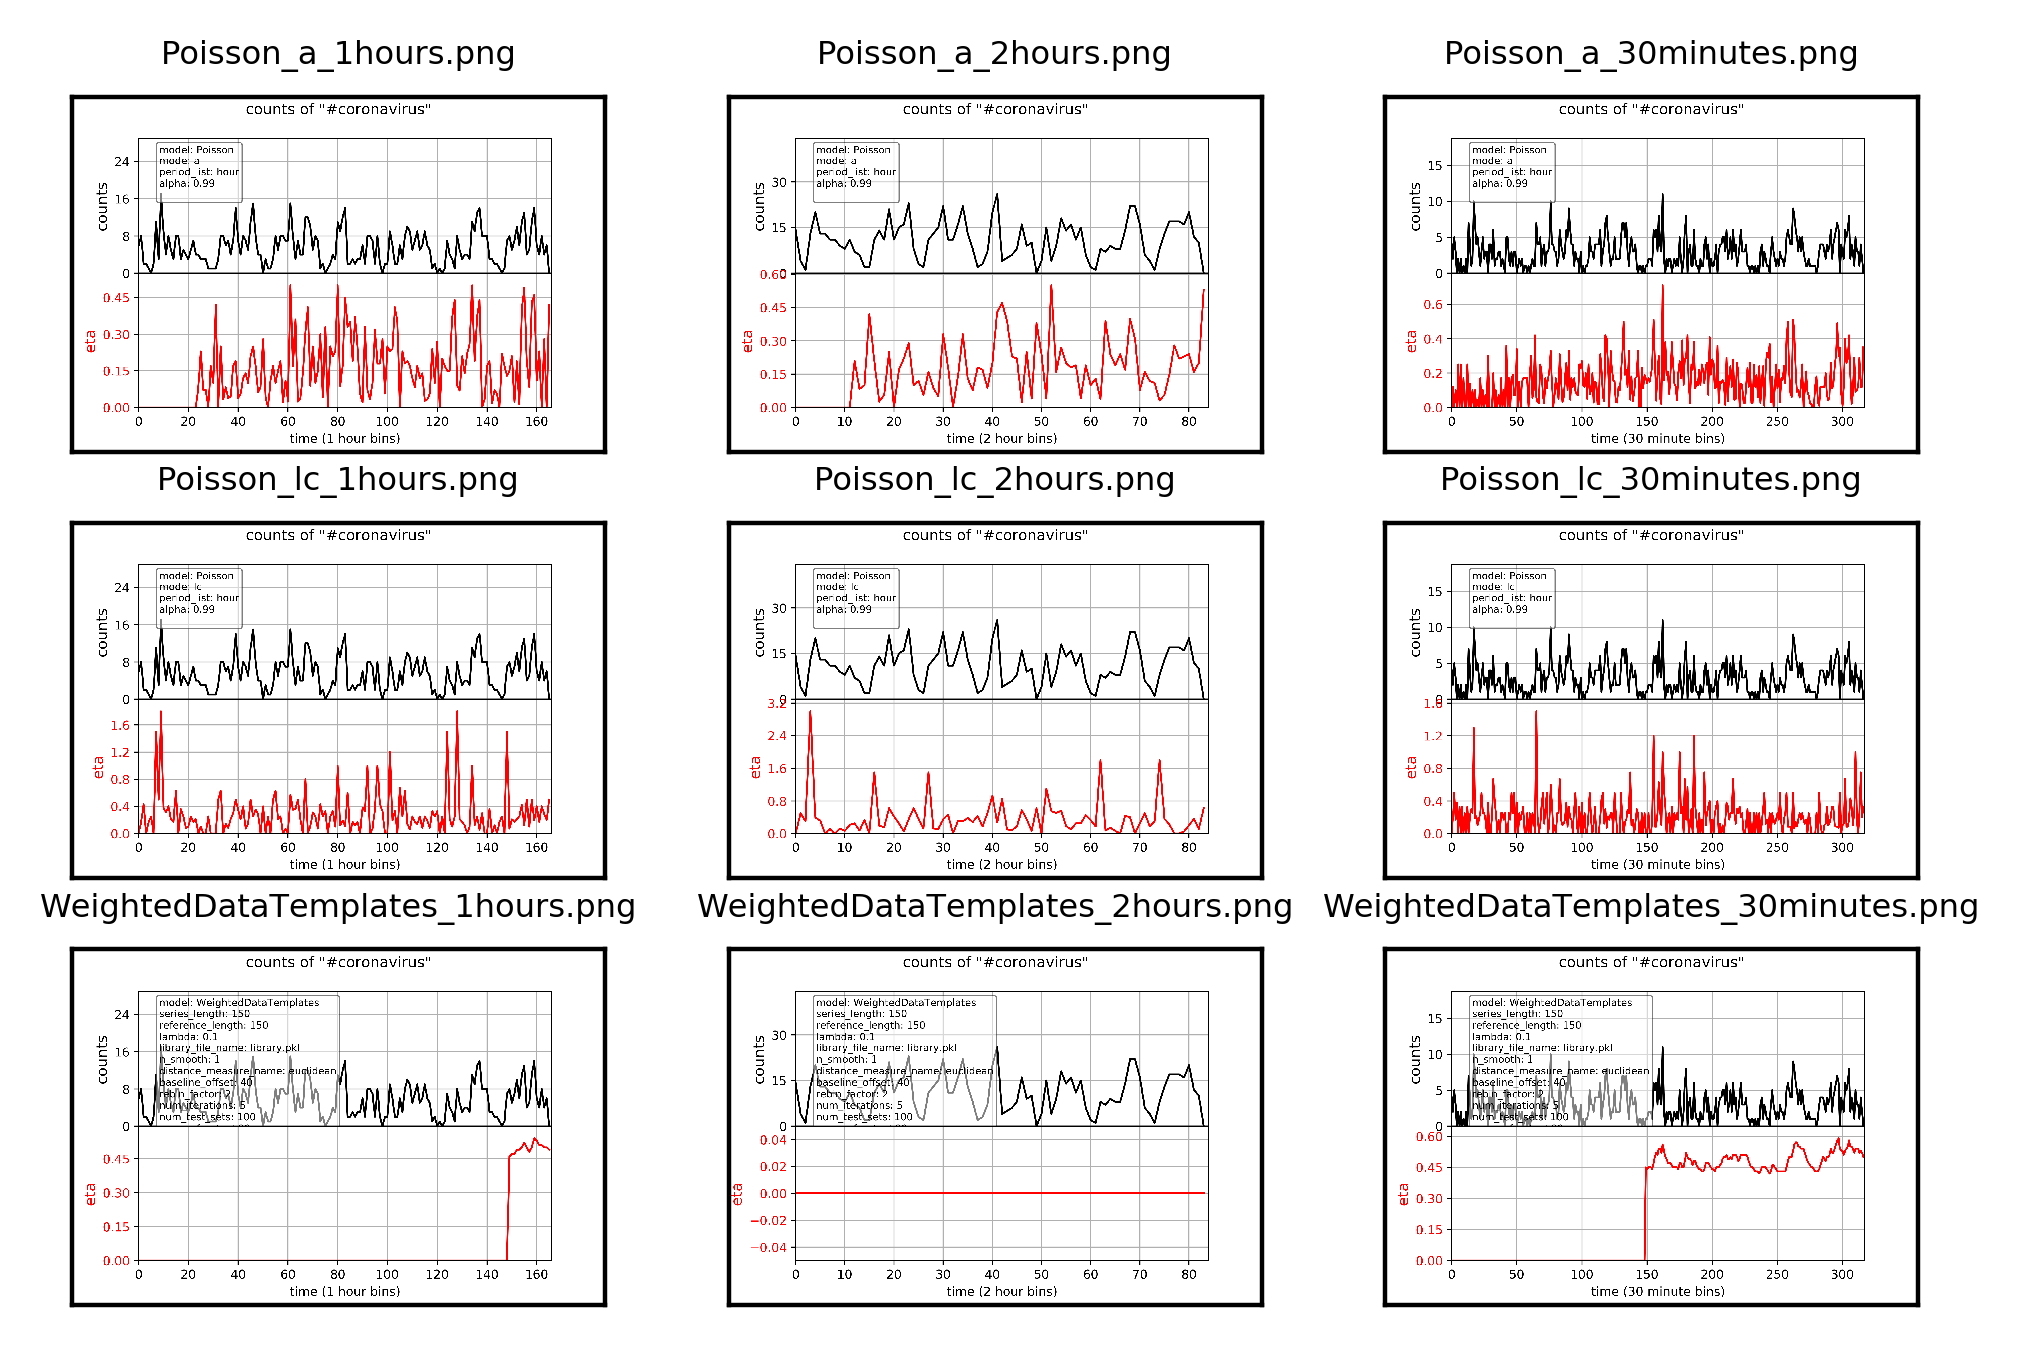

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


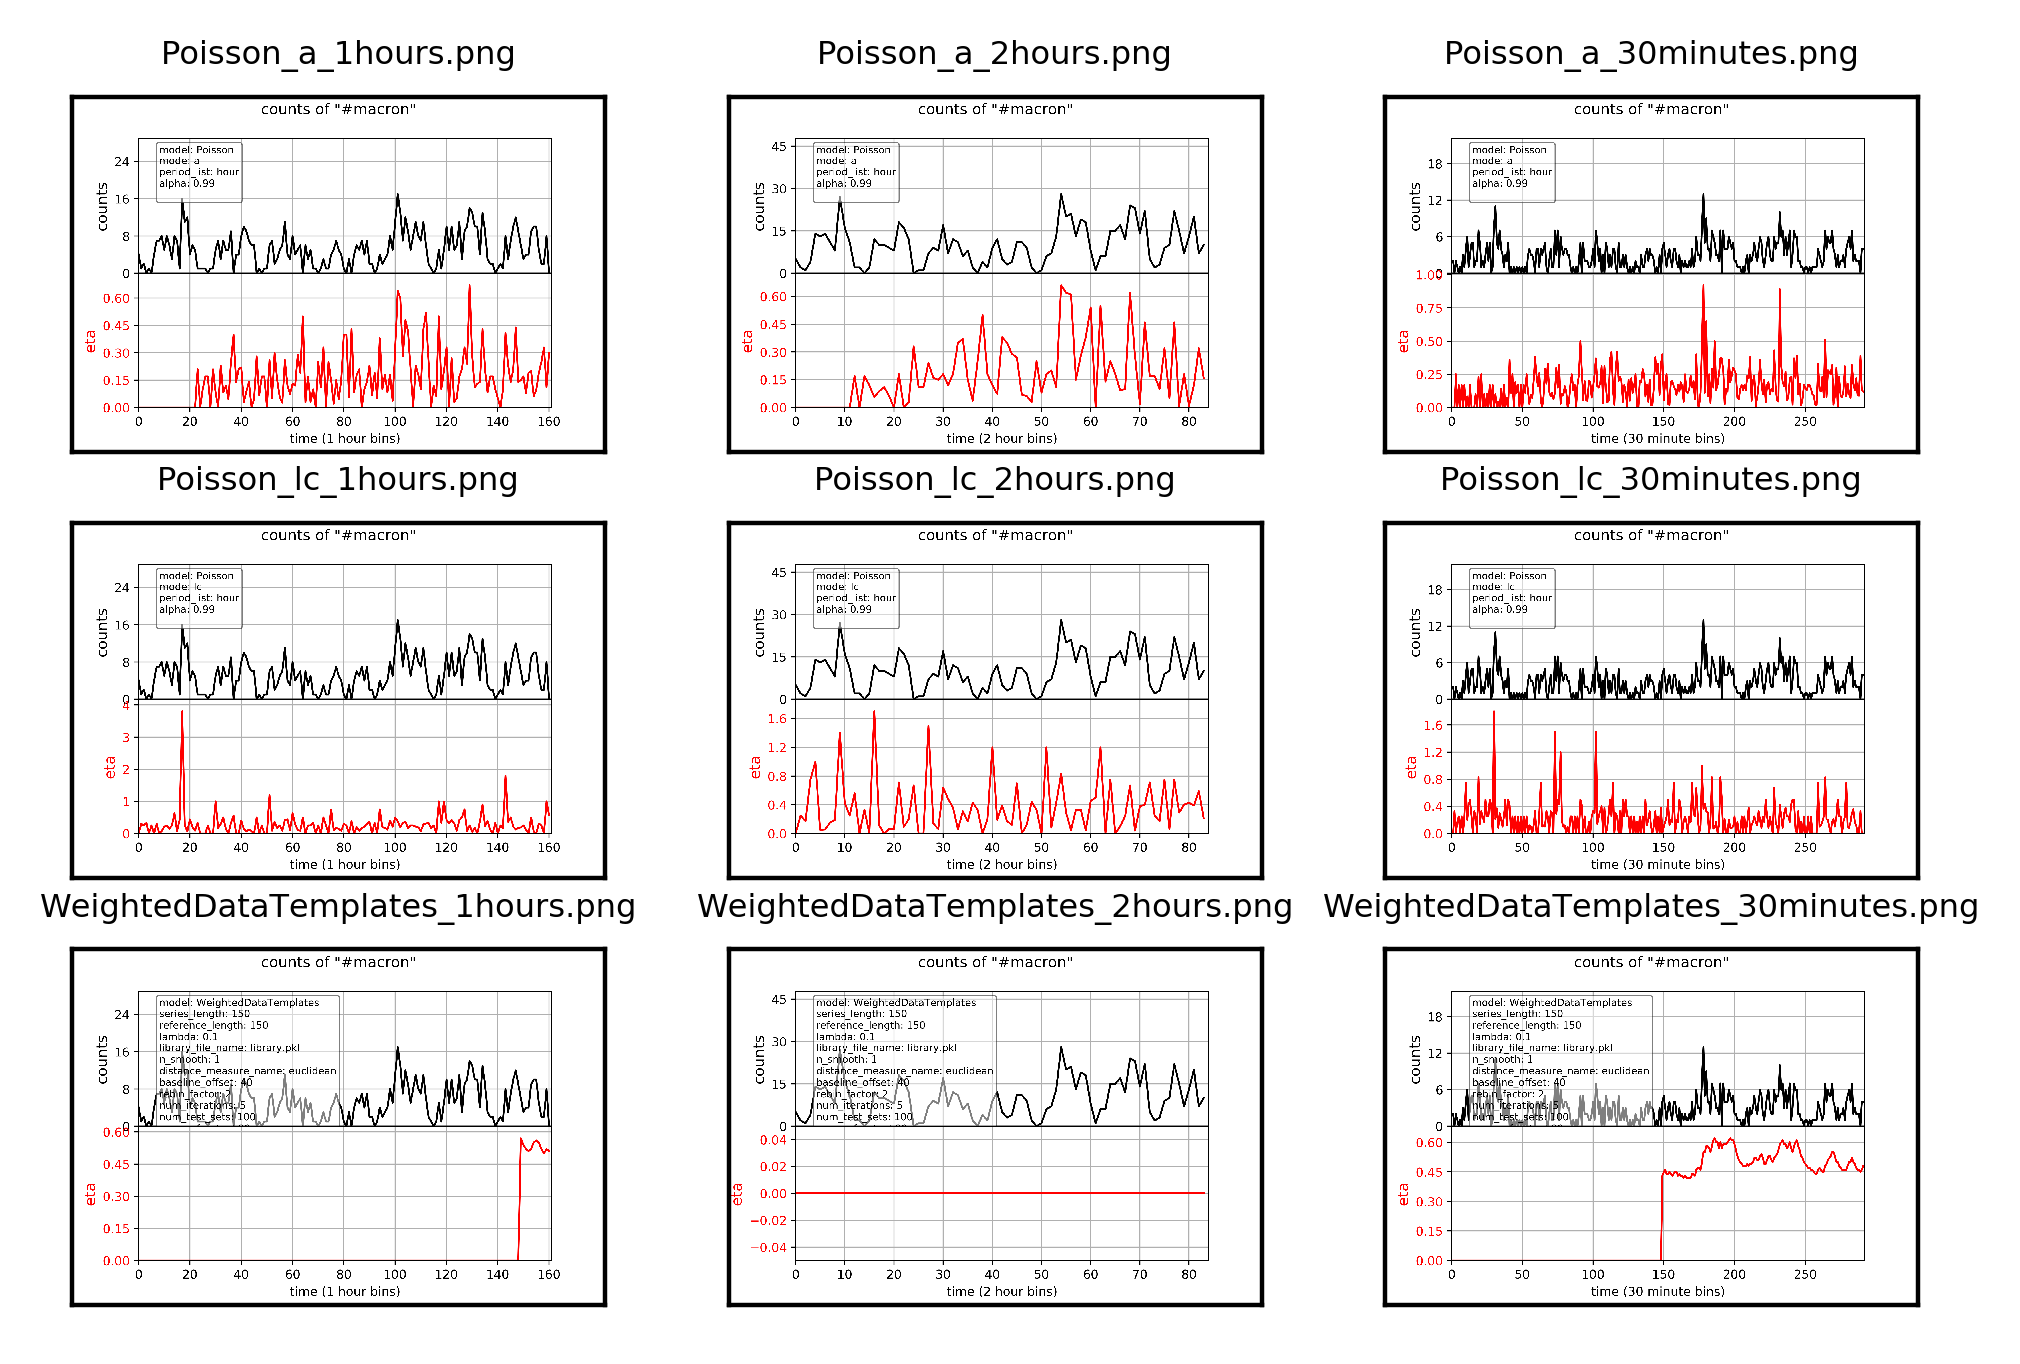

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


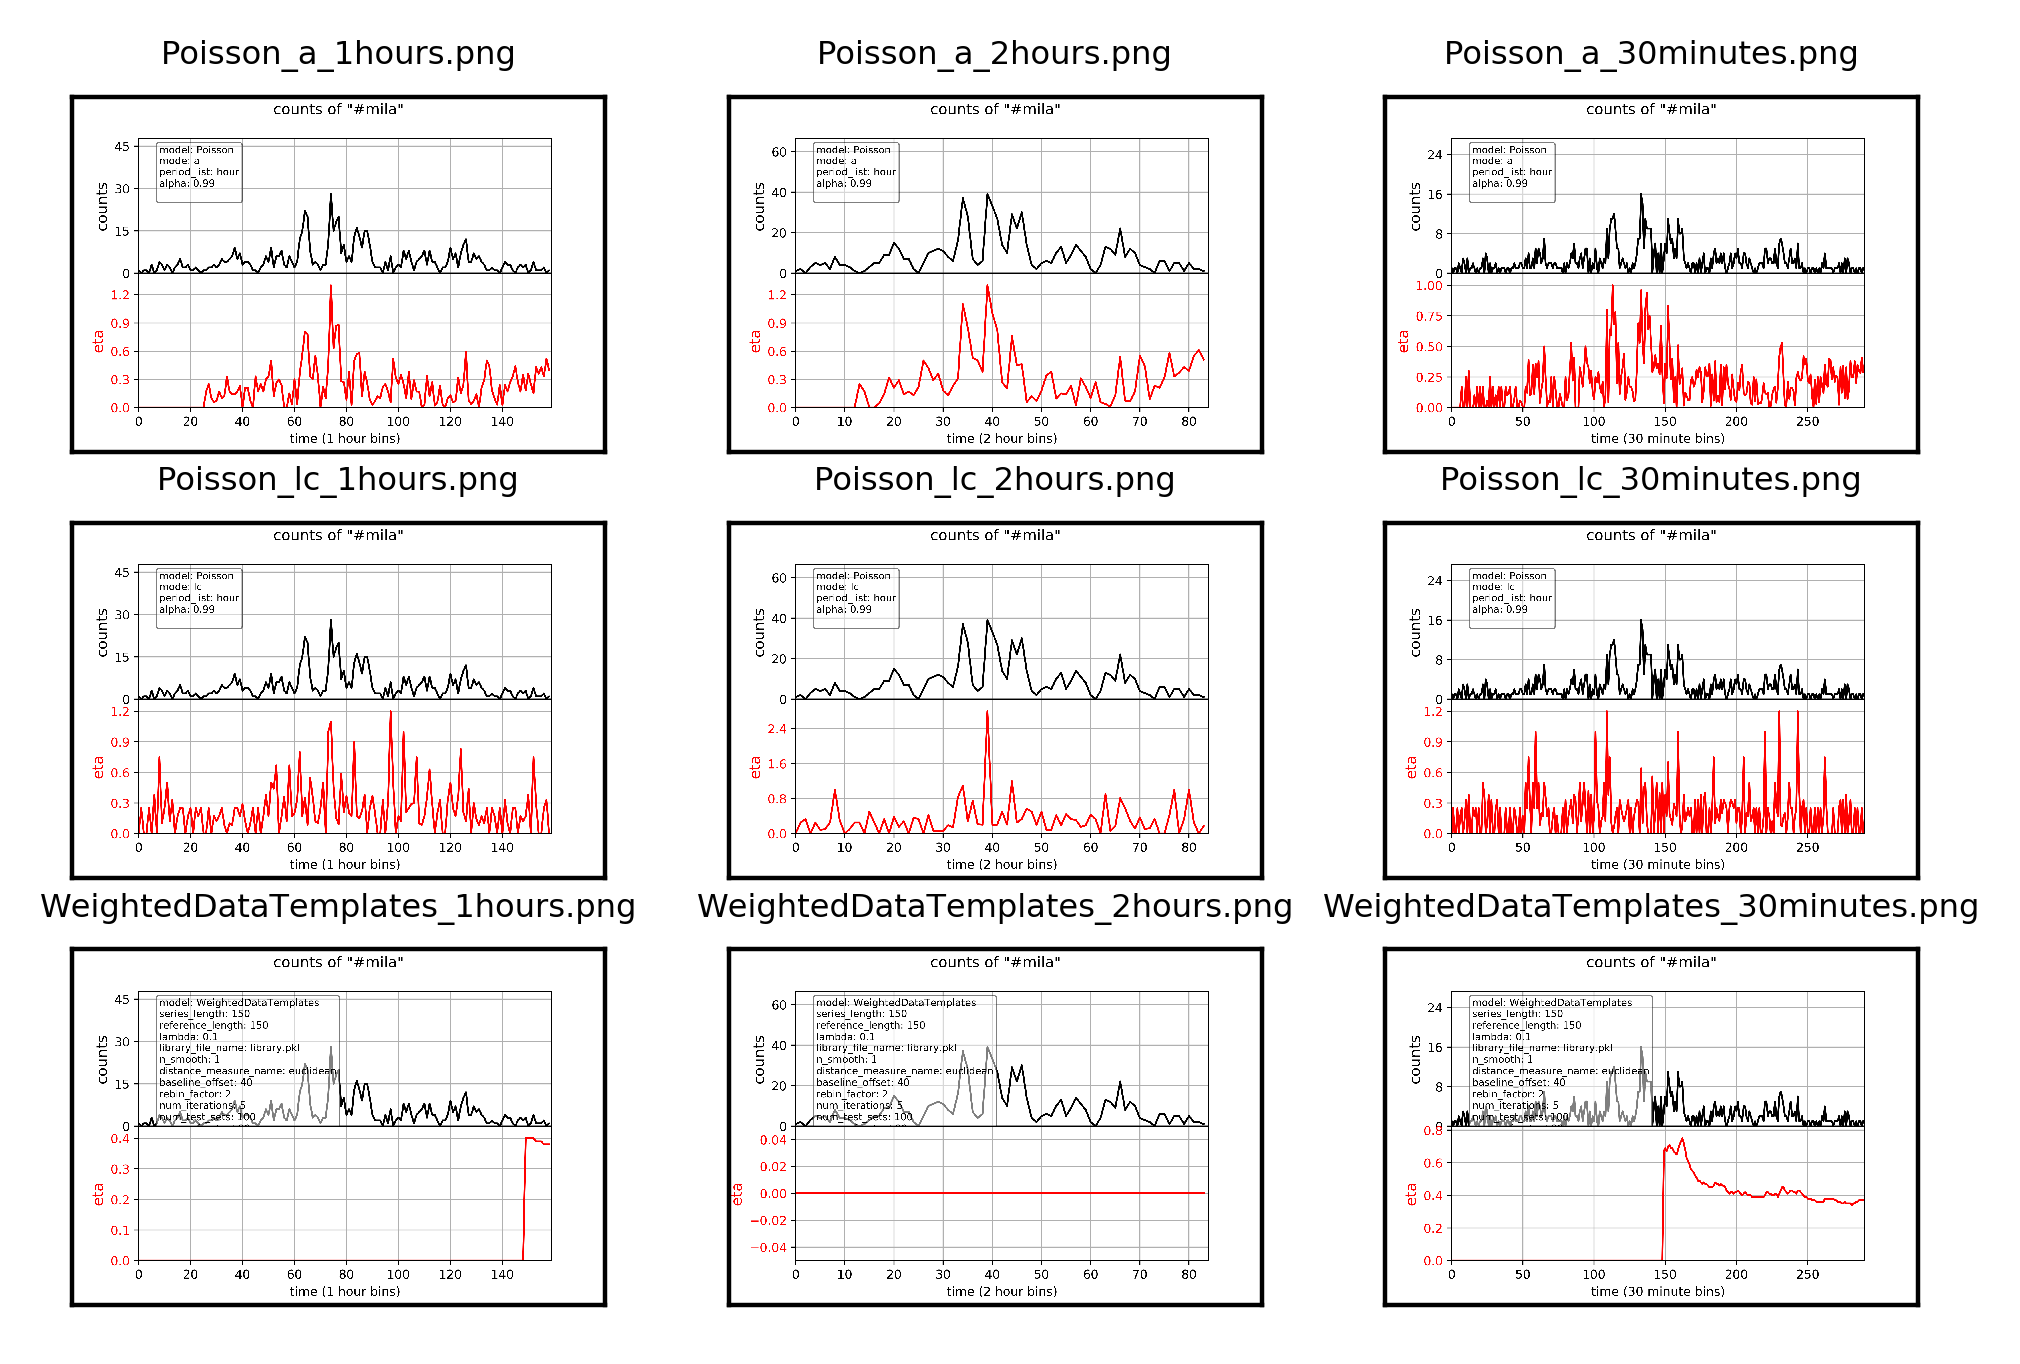

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


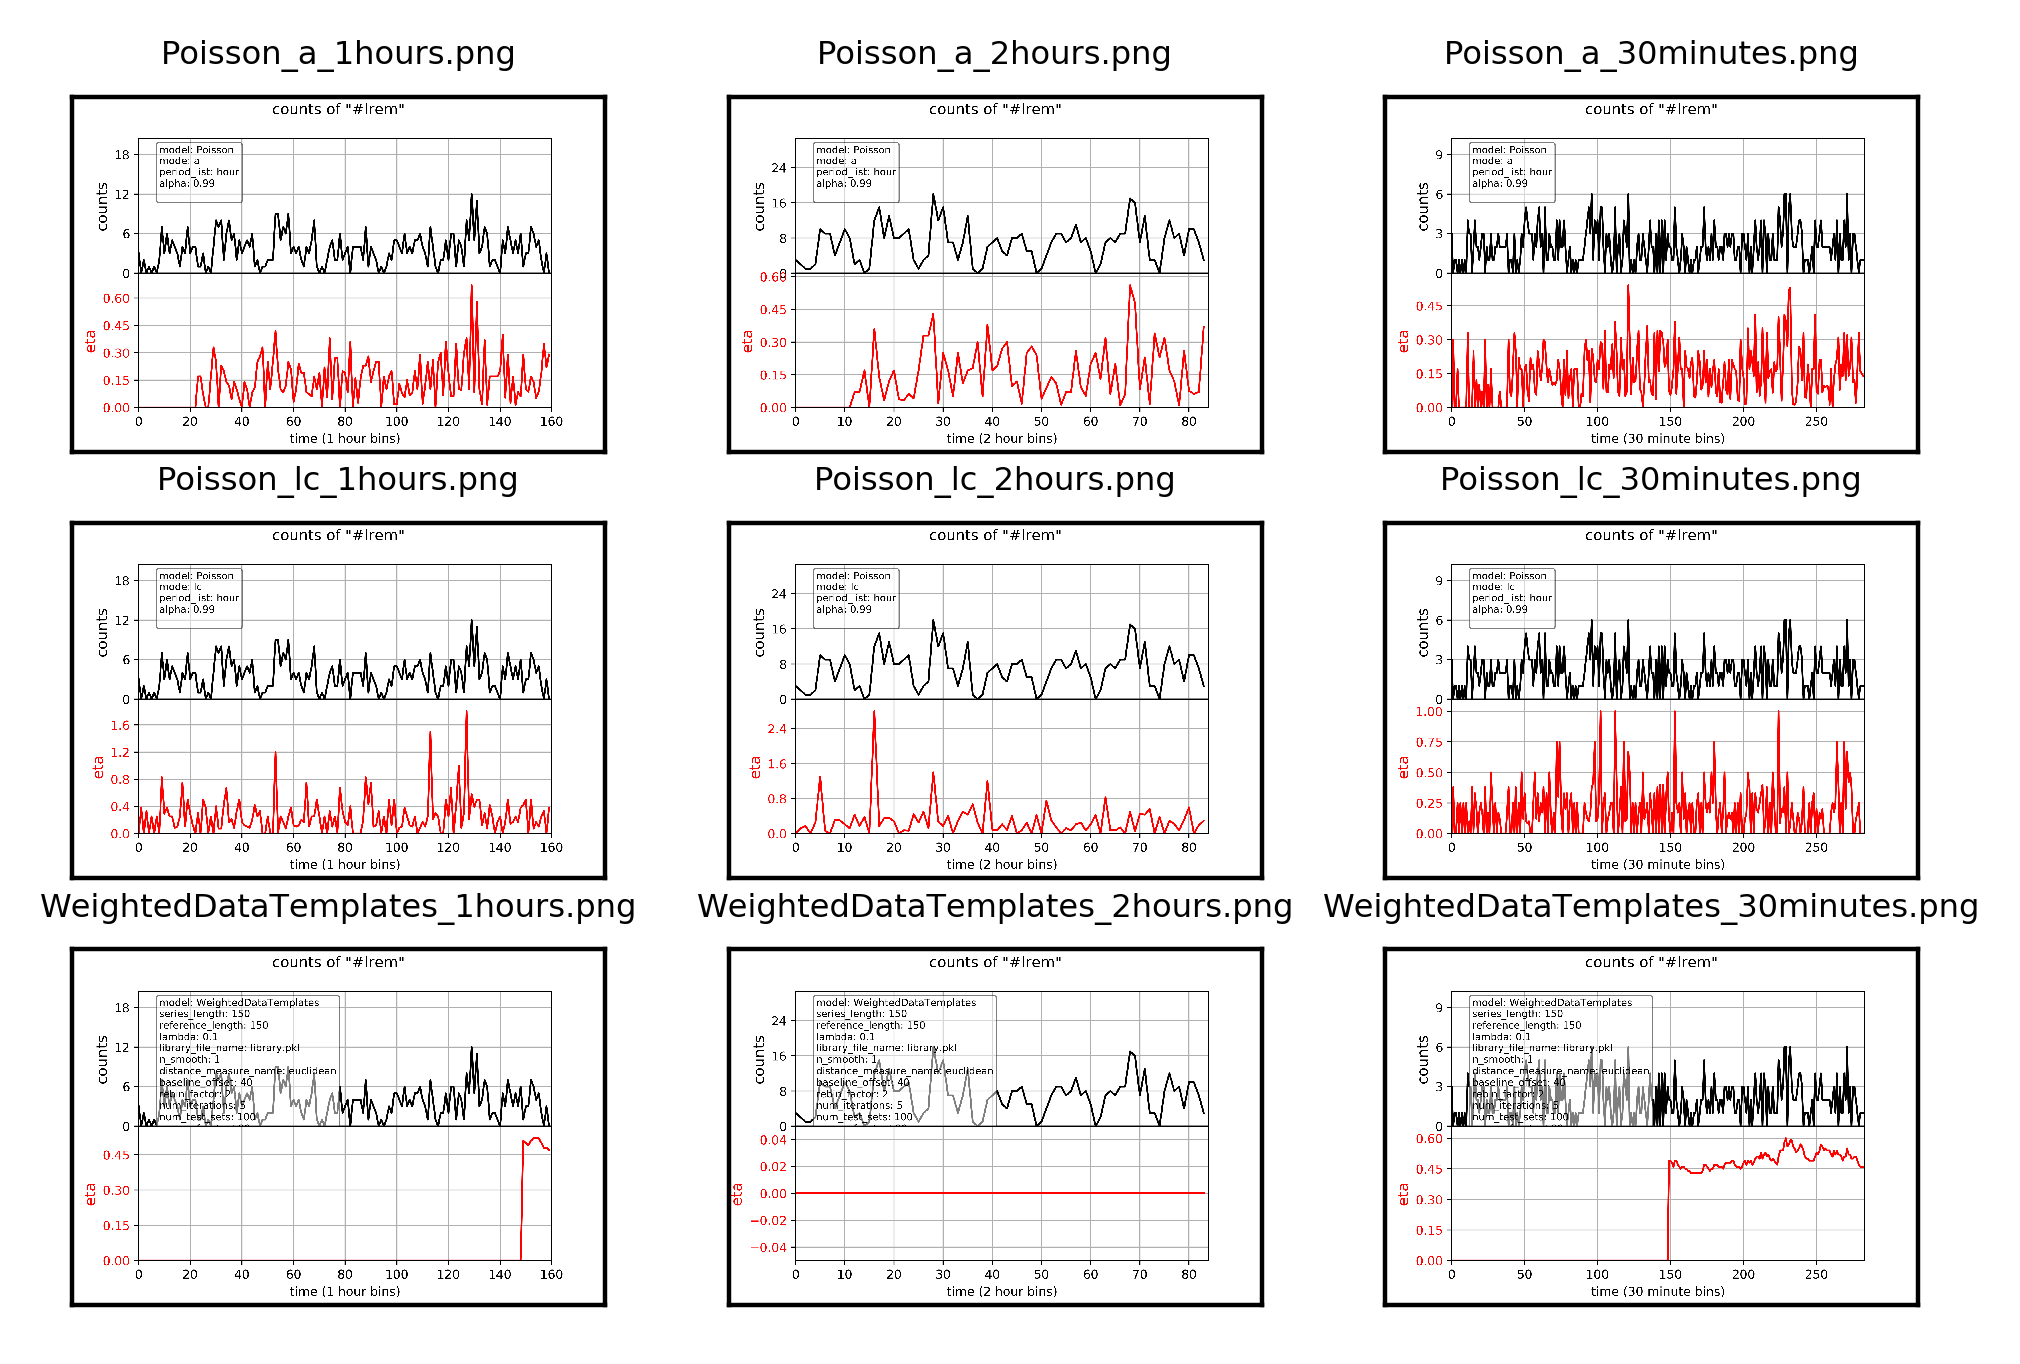

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


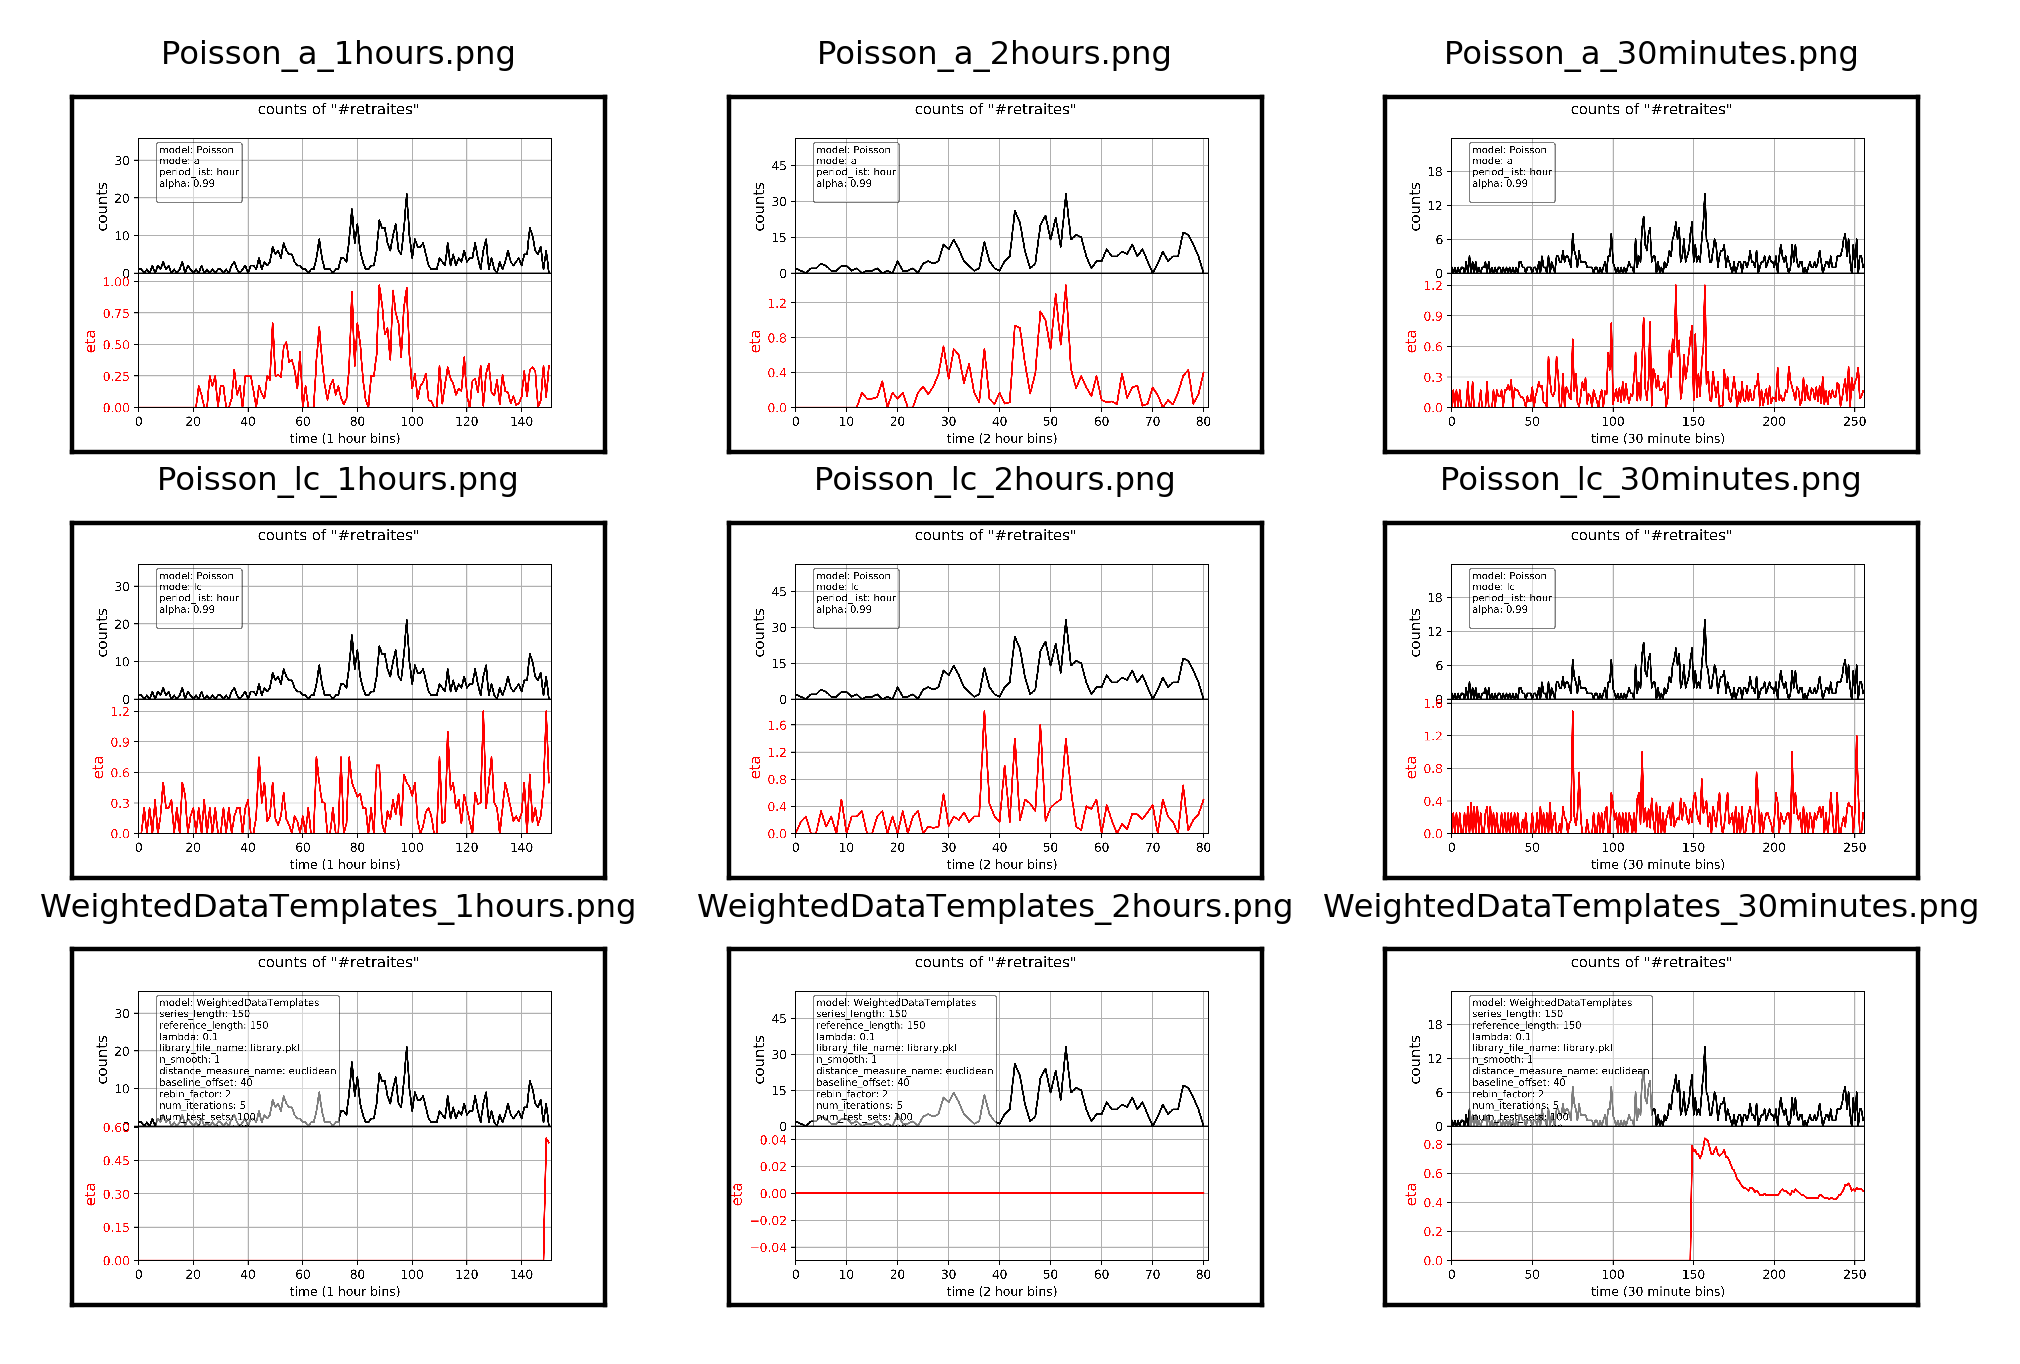

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


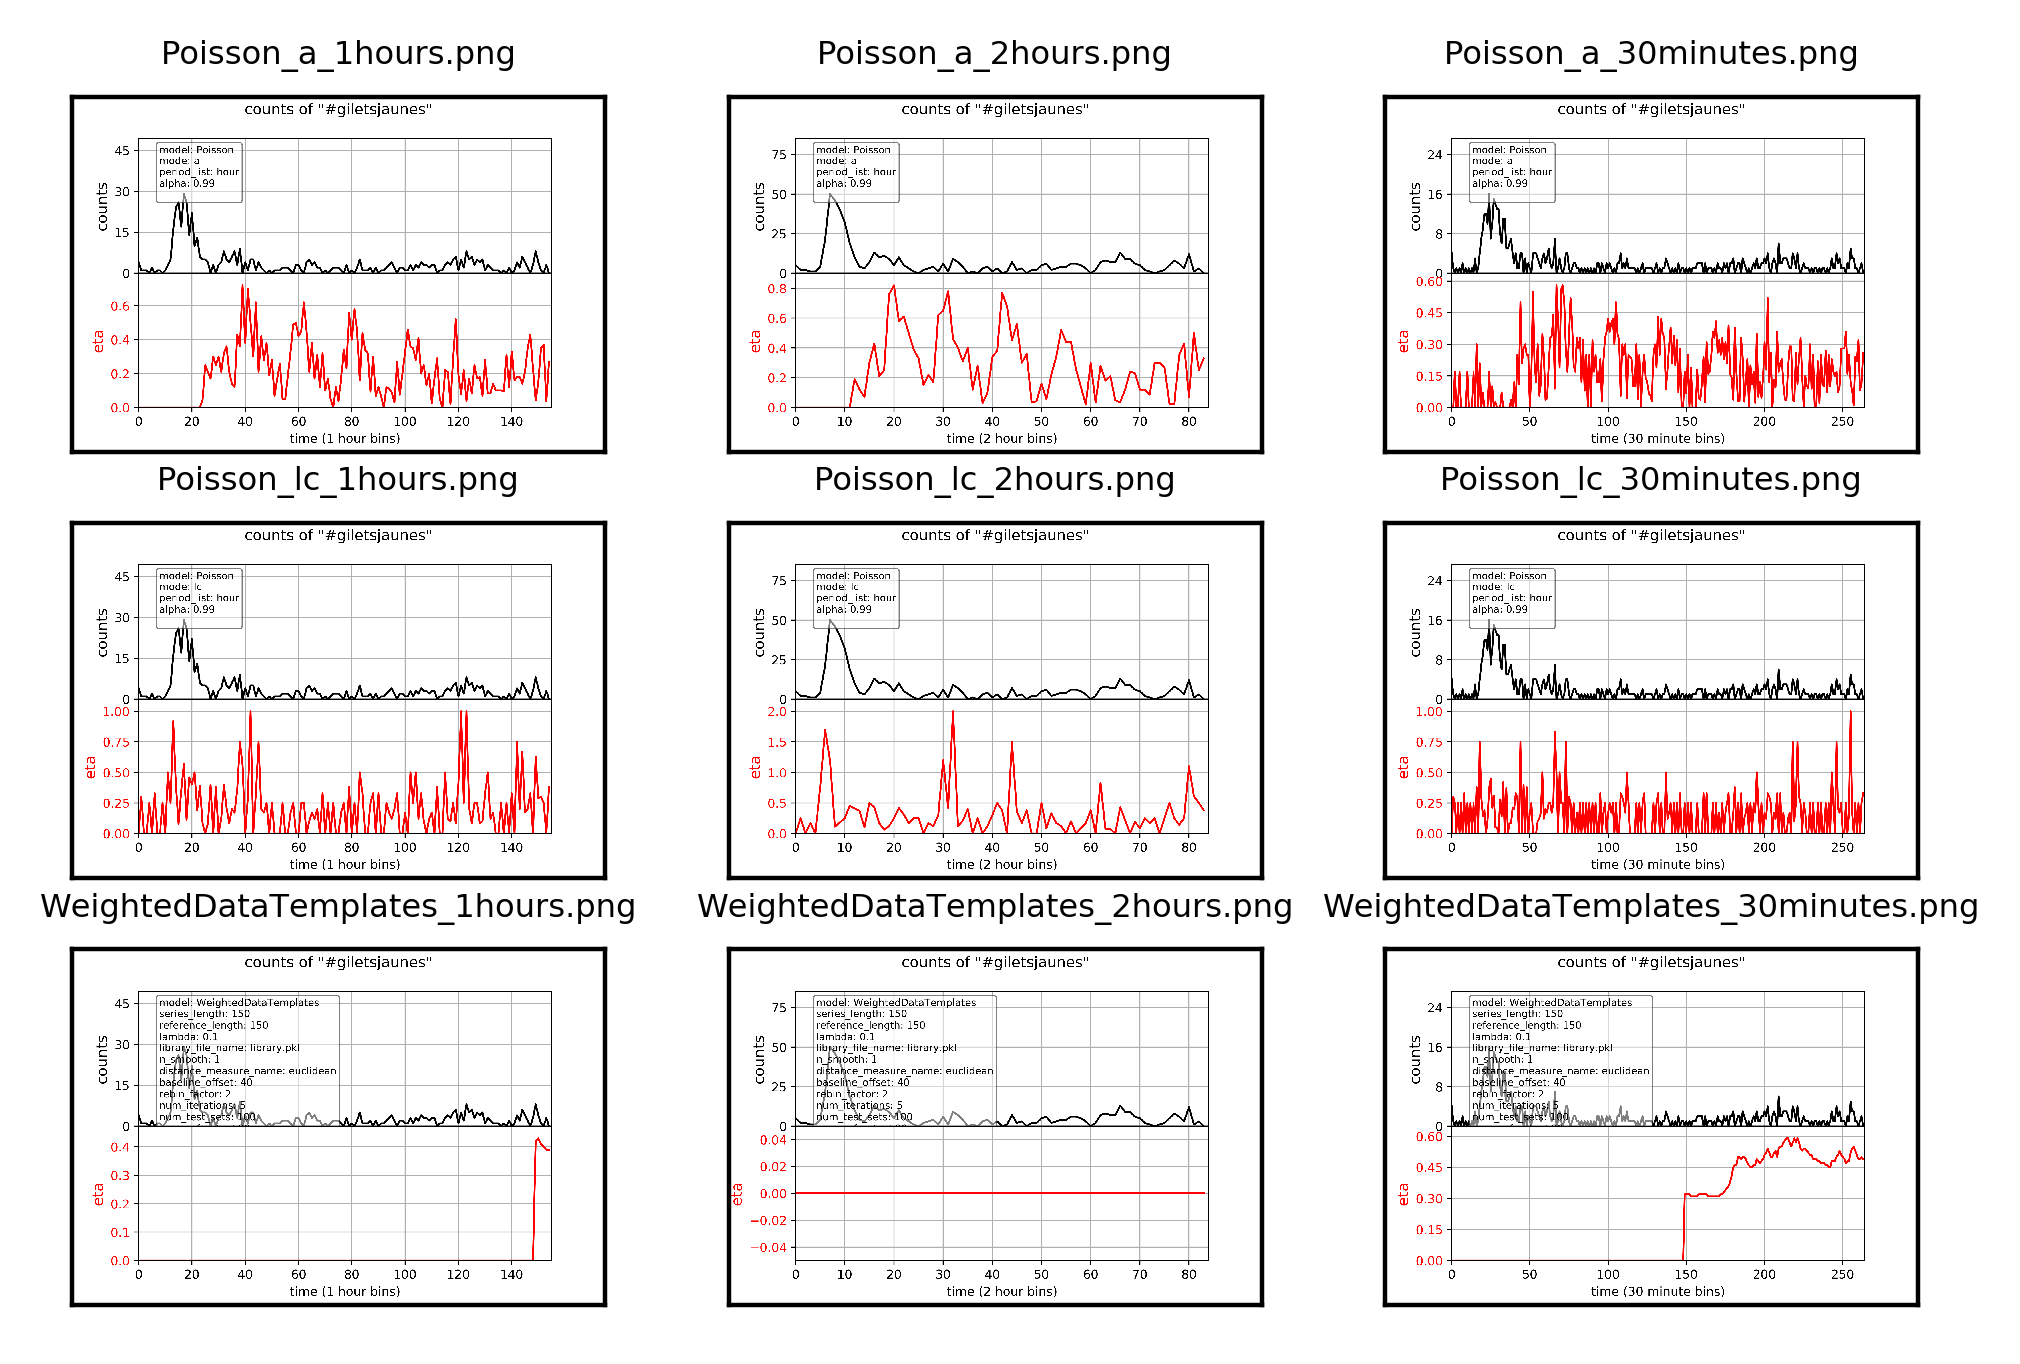

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


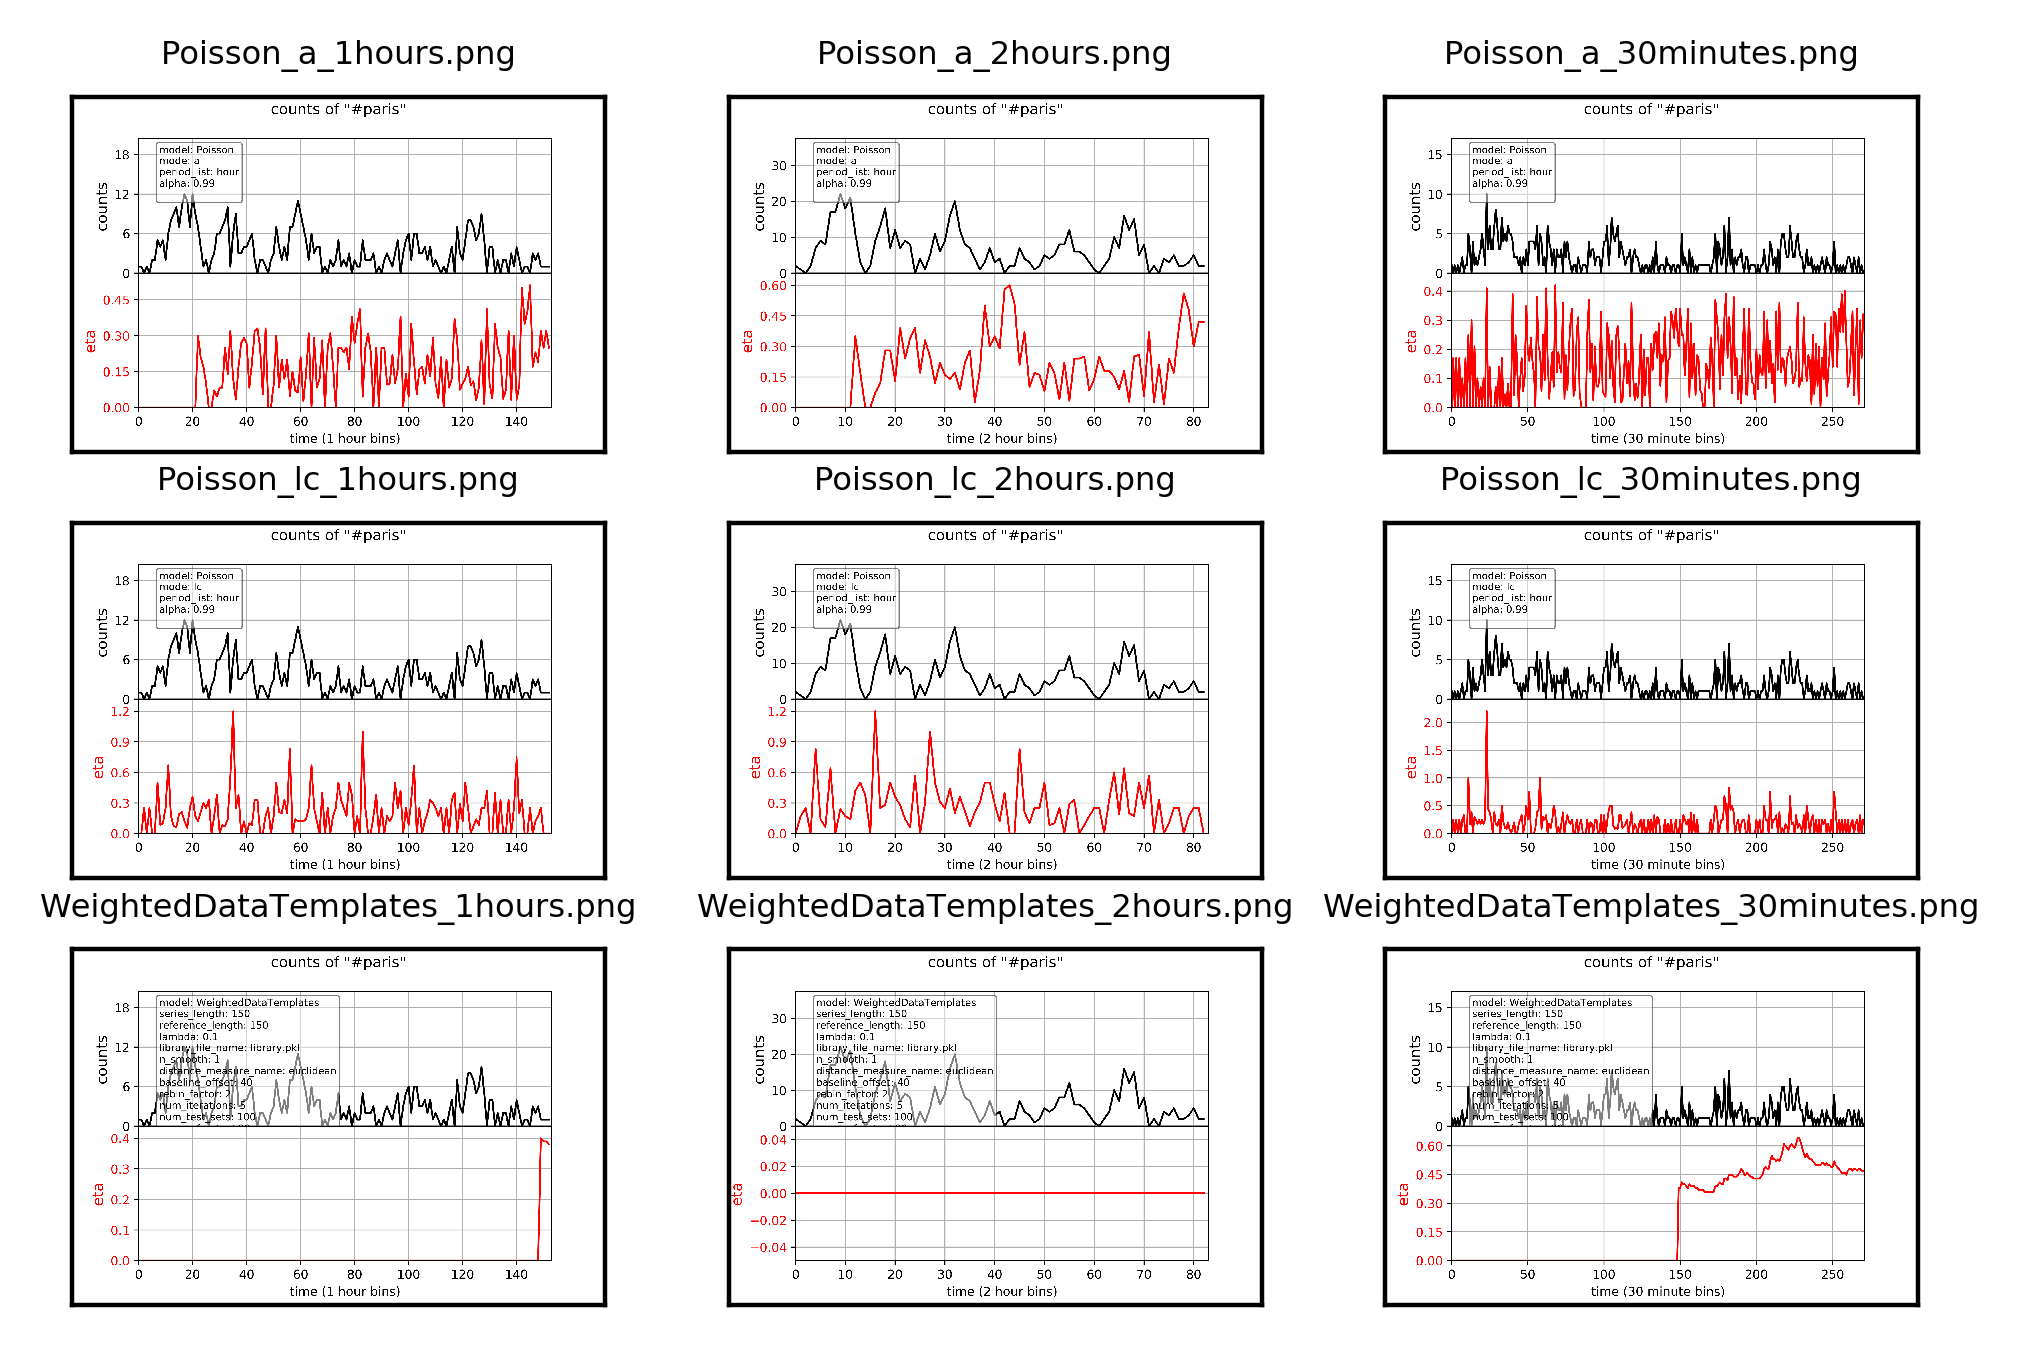

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


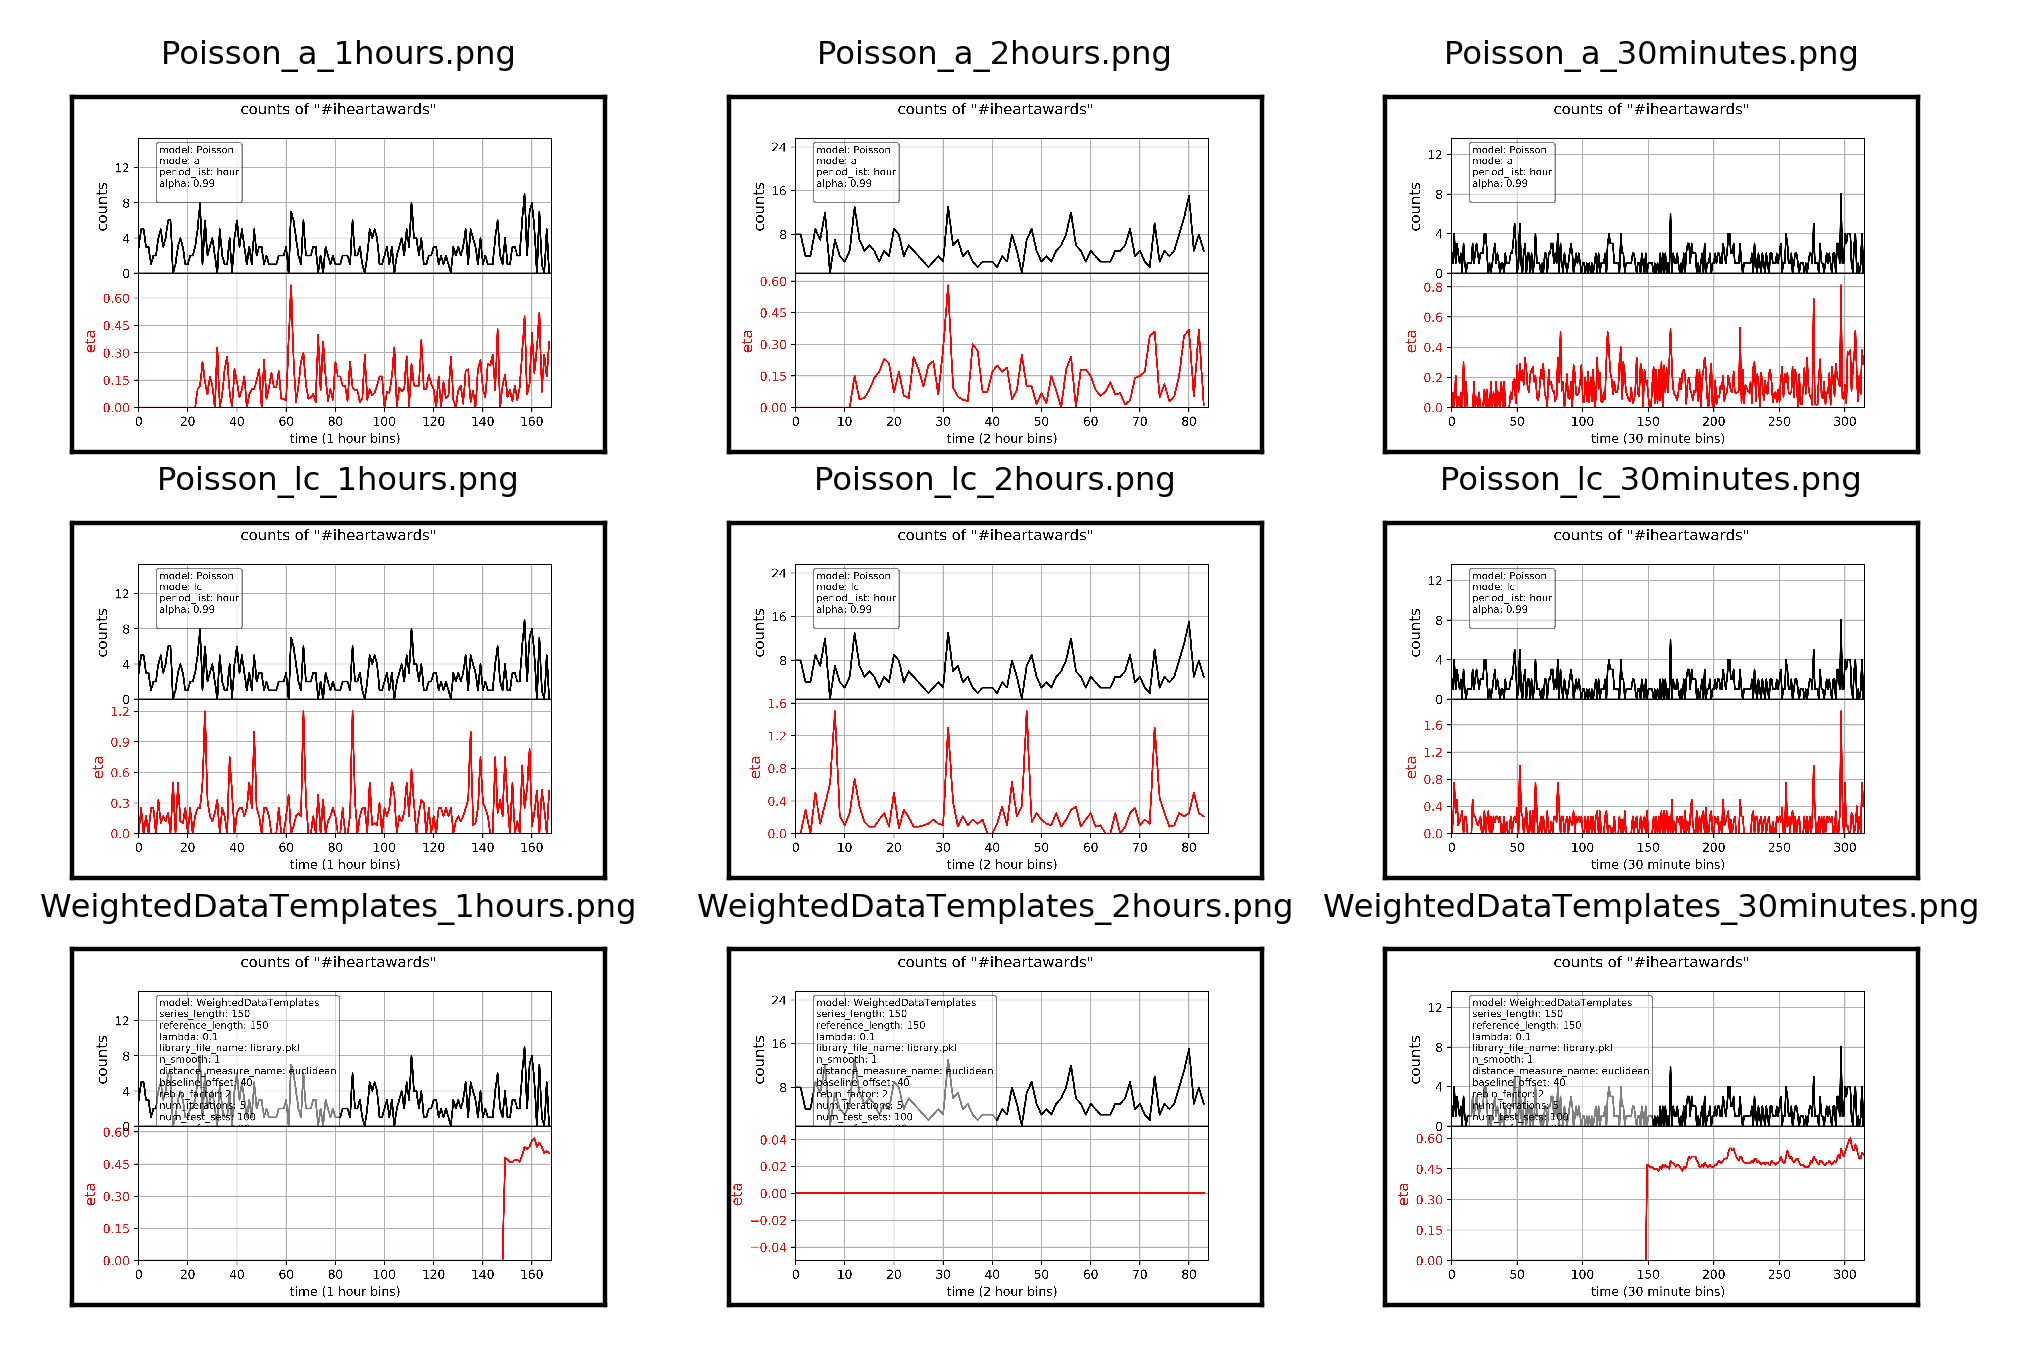

C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)
C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)
C:\logciel\Anaconda3\lib\site-packages\gnip_trend_detection\analysis.py:300: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax2.set_ylim(min_eta, max(eta)*1.1)


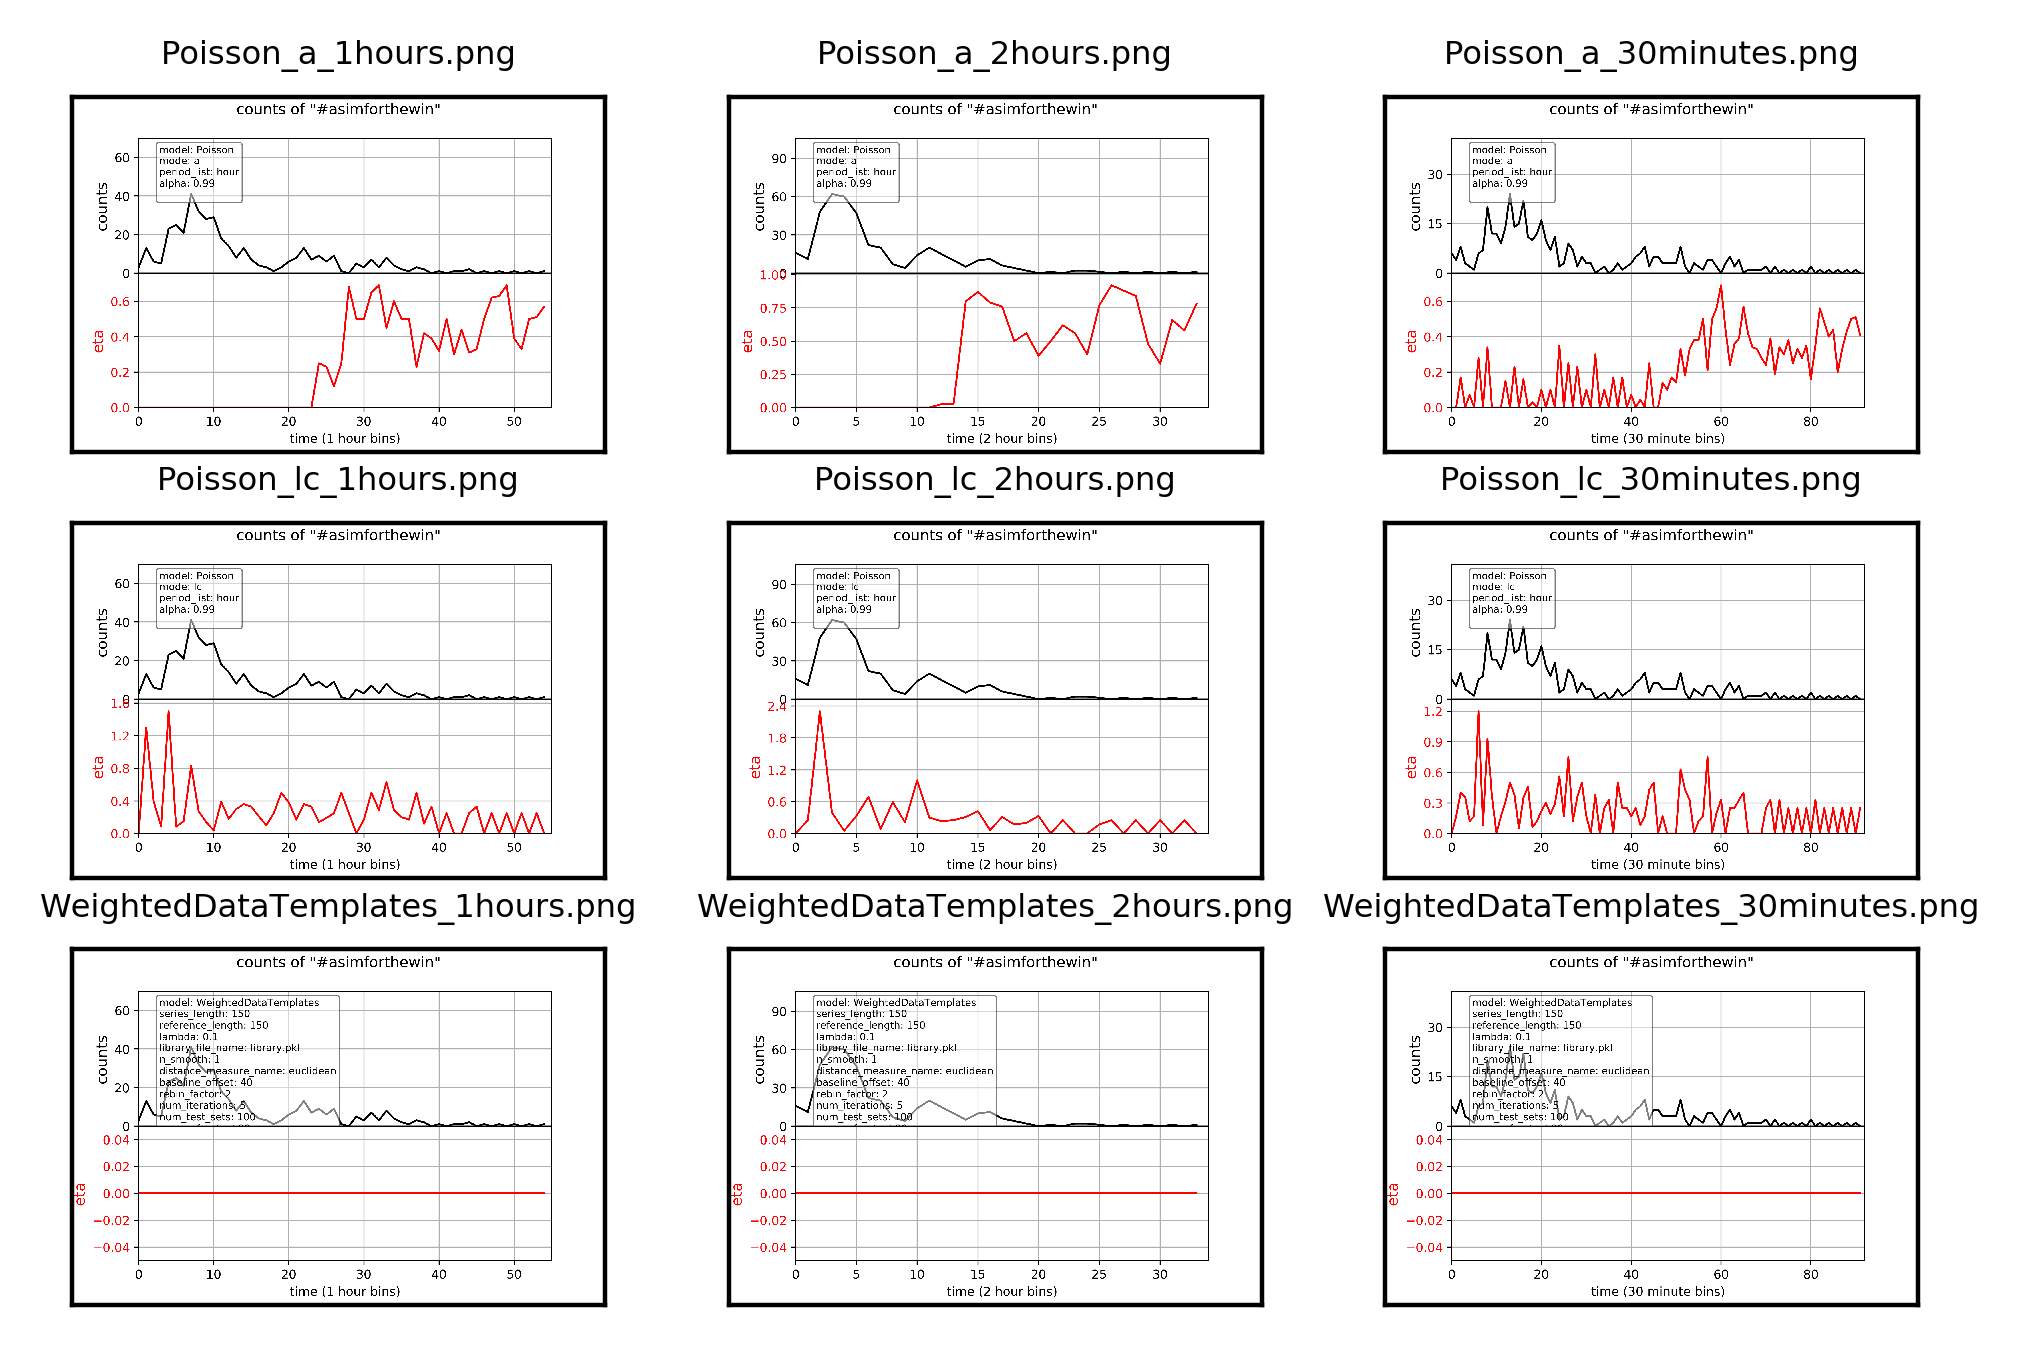

In [452]:
time_interval = ['30 minutes','1 hours', '2 hours']
model_conf = ['Poisson_lc', 'Poisson_a','WeightedDataTemplates']
for id_tag in range(10):
    tag = frequent_hashtags_10[id_tag]
    #### input file
    input_generator = list(csv.reader(open("hashtags/{}_10minutes.csv".format(tag))))
    #### There is a bug in gnip_trend_detection.analysis.rebin: it only deals with the date before 2020, 
    ###so here we do a fake date, change the 2020 to 2019
    for irow in input_generator:
        irow[0] = (datetime.strptime(irow[0],"%Y-%m-%d %H:%M:%S")- relativedelta(years=1)).strftime("%Y-%m-%d %H:%M:%S")  
    ## minus 1 year, change 2020 to 2019

    #### configurations
    config.set('plot', 'plot_title','counts of "#{}"'.format(tag))
    config.set('plot', 'plot_dir','./anomalies_detection/{}'.format(tag))
    for i in range(3):
        itime_interval = time_interval[i].split(' ')
        config.set('rebin', 'binning_unit',itime_interval[1])
        config.set('rebin', 'n_binning_unit',itime_interval[0])
        for j in range(3):
            imodel_conf = model_conf[j].split('_')
            model_name = imodel_conf[0]
            config.set('analyze', 'model_name',model_name)
            if j<2:
                config.set(model_name + "_model", 'mode',imodel_conf[1])
            config.set('plot', 'plot_file_name',model_conf[j]+'_'+itime_interval[0]+itime_interval[1])
            
            ### rebin the data  
            rebin_config = config.items("rebin") 
            kwargs = dict(rebin_config) 
            rebined_data = rebin(input_generator, **kwargs)
            
            ### models: WeightedDataTemplates, Possion("last count" mode  or "averaged mode")
            model_name = config.get("analyze","model_name")
            model_config = dict(config.items(model_name + "_model"))
            model = getattr(models,model_name)(config=model_config) 
            
            ### analyse by model and plot
            plotable_data = analyze(rebined_data,model)
            plot(plotable_data,config)
    showimg('./anomalies_detection/{}'.format(tag),3,3)

In [437]:
# img_path = './anomalies_detection/Macron'
# showimg(img_path,3,3)

### Question 5:  frequent words that together describe an event

In [8]:
df5 = df1.withColumn("hashtags",col("entities.hashtags")).select("hashtags","text")
df5 = df5.withColumn("hashtags", functions.explode("hashtags"))
df5 = df5.withColumn("hashtags",functions.lower(col("hashtags.text")))
df5.show()

+----------------+--------------------+
|        hashtags|                text|
+----------------+--------------------+
| flashbackfriday|RT @celinedion: H...|
|           ggrmc|@catisa92 C’est d...|
|         truchot|@catisa92 C’est d...|
|      niveauzero|@catisa92 C’est d...|
|            love|RT @VanessaDecker...|
|            fm20|RT @MaladrerieCae...|
|        chaelisa|RT @lalifoxy27: #...|
|          brexit|Ce qui a aussi ma...|
|               r|RT @lafouine78: T...|
|    bénédictions|RT @lafouine78: T...|
|           wpmoy|RT @CameronNewton...|
|     coronavirus|RT @ConflitsFR: ?...|
|    coronarvirus|RT @ConflitsFR: ?...|
|          brexit|RT @InfosFrancais...|
|              ue|@Mazagan_Ft @Siss...|
|              om|🔷 OM - Villas-Bo...|
|edouardphillippe|RT @CharliB977834...|
|           havre|RT @CharliB977834...|
|fonctionpublique|RT @PresseFSU: L'...|
|  bonneannee2020|RT @PresseFSU: L'...|
+----------------+--------------------+
only showing top 20 rows



In [461]:
top_words = []
for i in range(len(frequent_hashtags_10)):
    df_tmp = df5.filter(df5["hashtags"].isin(frequent_hashtags_10[i]))

    counts = frequent_words(df_tmp) # function defined in question 1
    
    remove_stop_words_count = counts.filter(counts["words_separated"].isin(stop_words_french.value)== False)
    top_words.append(remove_stop_words_count.limit(10).select('words_separated').toPandas()['words_separated'].tolist())

In [462]:
for i in range(len(top_words)):
    print("Frequent words for hashtag #",frequent_hashtags_10[i]," are: ",top_words[i])

Frequent words for hashtag # concours  are:  ['rt', '#concours', 'gagner', 'follow', '🎁', 'remporter', 'participer', 'tenter', '&amp;', '2']
Frequent words for hashtag # coronavirus  are:  ['rt', '#coronavirus', '@conflits_fr:', 'cas', 'épidémie', '#coronavirus.', '#chine', 'chinois', '🔴', '@conflitsfr:']
Frequent words for hashtag # macron  are:  ['rt', '#macron', '#lrem', 'français', 'président', '@tropical_boy:', '#enmarche', 'emmanuel', 'de…', 'riches']
Frequent words for hashtag # mila  are:  ['rt', '#mila', 'affaire', 'courage', '#mila,', '#quotidien', 'propos', 'dit', '@tprincedelamour:', 'droit']
Frequent words for hashtag # lrem  are:  ['#lrem', 'rt', 'députés', '#macron', '#enmarche', '@tropical_boy:', '#giletsjaunes', '#deuilenfant', '#lrem,', 'député']
Frequent words for hashtag # retraites  are:  ['rt', '#retraites', 'commission', 'réforme', 'spéciale', 'temps', 'vient', '@aquatennens:', 'd…', 'projet']
Frequent words for hashtag # giletsjaunes  are:  ['rt', '#giletsjaunes

### Question 7:  location of the events using the geolocation of tweets

In [16]:
df7 = df1.withColumn("hashtags",col("entities.hashtags")).select("hashtags","user.location")
df7 = df7.withColumn("hashtags", functions.explode("hashtags"))
df7 = df7.withColumn("hashtags",functions.lower(col("hashtags.text")))
df7 = df7.where(col("location").isNotNull())

In [17]:
df7.show()

+----------------+--------------------+
|        hashtags|            location|
+----------------+--------------------+
| flashbackfriday|       United States|
|           ggrmc|              France|
|         truchot|              France|
|      niveauzero|              France|
|            fm20|               Caen |
|        chaelisa|    Emmen, Nederland|
|          brexit|              France|
|           wpmoy|       Charlotte, NC|
|     coronavirus|            🇩🇿🇹🇷|
|    coronarvirus|            🇩🇿🇹🇷|
|          brexit|Ré-Bellerive-Bord...|
|              om|   Marseille, France|
|edouardphillippe|Planète Terre et ...|
|           havre|Planète Terre et ...|
|fonctionpublique|      Maine-et-Loire|
|  bonneannee2020|      Maine-et-Loire|
|      nowplaying|     Dour - Belgique|
|    iheartawards|Mandaluyong City,...|
|  bestmusicvideo|Mandaluyong City,...|
|    killthislove|Mandaluyong City,...|
+----------------+--------------------+
only showing top 20 rows



In [19]:
for i in range(len(frequent_hashtags_10)):
    print()
    print("For hashtag #", frequent_hashtags_10[i], ":")
    df7_tmp = df7.filter(df7["hashtags"] == frequent_hashtags_10[i])
    counts_tmp7 = df7_tmp.groupBy("location").count()
    counts7 = counts_tmp7.orderBy(counts_tmp7['count'].desc())
    
    counts7.show()


For hashtag # concours :
+--------------------+-----+
|            location|count|
+--------------------+-----+
|              France|   69|
|       Lille, France|   22|
|       Paris, France|   19|
|Ile-de-France, Fr...|   15|
|               Paris|    9|
|                 Ici|    7|
|Nord-Pas-de-Calai...|    6|
|            Belgique|    6|
|       Chez moi oklm|    5|
|    Bretagne, France|    5|
|   Aquitaine, France|    5|
|Nord, Nord-Pas-de...|    4|
|              Meerle|    4|
|    Bordeaux, France|    4|
|              FRANCE|    3|
|             Terre 6|    3|
|Partout Et Nulle ...|    3|
|Paris, Ile-de-France|    3|
|Dans le monde de ...|    3|
|         Springfield|    3|
+--------------------+-----+
only showing top 20 rows


For hashtag # coronavirus :
+--------------------+-----+
|            location|count|
+--------------------+-----+
|              France|   49|
|       Paris, France|   43|
|               Paris|   29|
|Ile-de-France, Fr...|   12|
|        Lyon, Franc

### Question8: NLP Tasks

#### named entities

In [10]:
import stanza
stanza.download("fr")
nlp = stanza.Pipeline(lang='fr', processors='tokenize,ner')

2021-03-27 02:40:22 INFO: Downloading default packages for language: fr (French)...
2021-03-27 02:40:23 INFO: File exists: C:\Users\WANG Jie\stanza_resources\fr\default.zip.
2021-03-27 02:40:29 INFO: Finished downloading models and saved to C:\Users\WANG Jie\stanza_resources.
2021-03-27 02:40:29 WARNING: Language fr package default expects mwt, which has been added
2021-03-27 02:40:29 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| ner       | wikiner |

2021-03-27 02:40:30 INFO: Use device: gpu
2021-03-27 02:40:30 INFO: Loading: tokenize
2021-03-27 02:40:39 INFO: Loading: mwt
2021-03-27 02:40:39 INFO: Loading: ner
2021-03-27 02:40:40 INFO: Done loading processors!


In [39]:
def name_entities(text):
    doc = nlp(text)
    entities = [(ent.text).lower() for sent in doc.sentences for ent in sent.ents]
    dict_enti = {}
    for e in entities:
        if e in dict_enti:
            dict_enti[e] +=1
        else:
            dict_enti[e] = 1
            
    return dict_enti

In [53]:
for i in range(10):
    tag = frequent_hashtags_10[i]
    print("{}. #{}: ".format(i+1, tag))
    df_tmp = df5.filter(df5["hashtags"] ==tag)
    df_tmp_text = df_tmp.select("text").collect()
    
    entities_global_count = {}
    for i in df_tmp_text:
        dict_count = name_entities(i[0])
        for k,v in dict_count.items():
            if k in entities_global_count:
                entities_global_count[k] += v
            else:
                entities_global_count[k] = v

    sort_enti= ["{}: {}".format(k,v) for k, v in sorted(entities_global_count.items(), key=lambda item: item[1], reverse=True)]
    print(sort_enti[:10])   

1. #concours: 
['rt: 1355', '#concours: 263', 'follow: 256', 'concours: 129', 'paypal: 84', 'follow @nintendalerts: 72', 'topachat: 38', 'rtx: 38', 'nvidia rtx: 37', 'nintendo switch: 36']
2. #coronavirus: 
['rt: 622', '#coronavirus: 547', 'chine: 83', '#chine: 57', '#wuhan: 54', 'li wenliang: 40', 'coronavirus: 39', 'wuhan: 36', '#pangolin: 22', 'france: 20']
3. #macron: 
['rt: 515', '#macron: 468', 'macron: 164', 'lrem: 66', 'français: 49', '#giletsjaunes: 35', 'ofce: 34', 'flash: 33', 'rt @brevesdepresse: 32', 'emmanuel #macron: 29']
4. #mila: 
['rt: 511', '#mila: 449', 'mila: 127', '#quotidien: 25', 'ségolène royal: 24', 'affaire #mila: 20', 'république: 20', 'islam: 20', '#hanouna: 17', 'mme @royalsegolene: 16']
5. #lrem: 
['rt: 343', 'lrem: 280', '#lrem: 189', 'macron: 37', '#macron: 34', '#giletsjaunes: 18', 'rt @bassounov: 18', 'ça: 17', '@bfmtv: 12', 'nîmes gard: 11']
6. #retraites: 
['rt: 425', 'retraites: 121', 'lrem: 88', '#retraites: 78', 'commission spéciale #retraites: 4

#### sentiment analyze

In [9]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [10]:
def senti_analyze(sent):
    vs = analyzer.polarity_scores_max(sent)
    return Row('neg', 'neu', 'pos', 'compound') (vs['neg'], vs['neu'], vs['pos'], vs['compound'])

In [11]:
schema = StructType([
    StructField("neg", FloatType(), False),
    StructField("neu", FloatType(), False),
    StructField("pos", FloatType(), False),
    StructField("compound", FloatType(), False)])
senti_fn  = functions.udf(senti_analyze, schema)

In [34]:
def overall_senti(score):
    score = float(score)
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [44]:
hashtags =[]
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
overall_list =[]
for i in range(10):
    tag_tmp = frequent_hashtags_10[i]
    print(tag_tmp)
    hashtags.append(tag_tmp)
    df_tmp = df5.filter(df5["hashtags"] == tag_tmp)
    score_tmp = df_tmp.withColumn("scoring", senti_fn(col("text")))
    score_tmp = score_tmp.select("scoring.neg","scoring.neu", "scoring.pos", "scoring.compound" )
    
    score_avg =score_tmp.groupby().mean()
    score_array = score_avg.collect()[0]
    compound_list.append(score_array['avg(compound)'])
    positive_list.append(score_array['avg(pos)'])
    negative_list.append(score_array['avg(neg)'])
    neutral_list.append(score_array['avg(neu)'])
    overall_list.append(overall_senti(score_array['avg(compound)']))

concours
coronavirus
macron
mila
lrem
retraites
giletsjaunes
paris
iheartawards
asimforthewin


In [45]:
sentiments = {"hasgtags": hashtags,
              "Positive": positive_list,
              "Negative": neutral_list,
              "Neutral": negative_list,
              "Compound": compound_list,
              "Overall Sentiment": overall_list}
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.head(10)

,hasgtags,Positive,Negative,Neutral,Compound,Overall Sentiment
0,concours,0.218079,0.702950,0.078945,0.455680,positive
1,coronavirus,0.134116,0.726801,0.139051,-0.012010,neutral
2,macron,0.154254,0.717701,0.128041,0.084486,positive
3,mila,0.169480,0.619614,0.210911,-0.102657,negative
4,lrem,0.148087,0.722320,0.129595,0.042920,neutral
5,retraites,0.229381,0.662075,0.108573,0.261421,positive
6,giletsjaunes,0.128815,0.747919,0.123235,0.021533,neutral
7,paris,0.123695,0.746726,0.129579,-0.045267,neutral
8,iheartawards,0.044785,0.938356,0.016859,0.057717,positive
9,asimforthewin,0.133691,0.837136,0.029176,0.255577,positive


### Question 9: Tweet clusters

In [11]:
# prepare datasets

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
df9 = df1.withColumn("hashtags",col("entities.hashtags")).select("hashtags","text")
df9 = df9.withColumn("hashtags", functions.explode("hashtags"))
df9 = df9.withColumn("hashtags",functions.lower(col("hashtags.text")))

df9 = df9.filter(df9["hashtags"].isin(frequent_hashtags_10))

In [12]:
df9.count()

6641

In [13]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, StopWordsRemover
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens")
hashingTF = HashingTF(inputCol="stopWordsRemovedTokens", outputCol="rawFeatures", numFeatures=2000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=10)

from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])

model = pipeline.fit(df9)

results = model.transform(df9)
results.cache()

DataFrame[hashtags: string, text: string, tokens: array<string>, stopWordsRemovedTokens: array<string>, rawFeatures: vector, features: vector, prediction: int]

In [14]:
results.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   52|
|         6|    5|
|         3|   14|
|         5|  168|
|         9|   11|
|         4|   16|
|         8|    8|
|         7|  642|
|         2|   19|
|         0| 5706|
+----------+-----+



In [15]:
df9.groupby("hashtags").count().show()

+-------------+-----+
|     hashtags|count|
+-------------+-----+
|     concours| 1133|
|asimforthewin|  404|
|       macron|  820|
|        paris|  537|
|    retraites|  557|
|         lrem|  563|
|         mila|  723|
|  coronavirus|  908|
| iheartawards|  455|
| giletsjaunes|  541|
+-------------+-----+

